In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import special


import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d-goodres'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-mediumbad'






#input_dir = 'bootstrap-toy-study8a-1d-2a-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-2a-nominal-resolution'


#input_dir = 'bootstrap-toy-study8a-1d-2a'



#hist_nbins = 10
hist_nbins = 20
#hist_nbins = 40


fitType = 'bin center approximation'
#fitType = 'integral within bin'





rcond_val = 0.001

diagonal_constant = 1.0







hist_xlow = -3.
hist_xhigh = 3.

#hist_xlow = -2.
#hist_xhigh = 2.



generate_test_data = True
#generate_test_data = False




with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (100000, 1)
 shape of true_pts:   (10000, 1)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)
ngen_true = int(cu.get_par( config_file, "ngen_true"))
print(' ngen_true = %d\n' % ngen_true )



 Number of feature dimensions: 1


 ngen_true = 10000



In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

In [6]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

In [7]:


with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)

main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

print('\n\n')
print(' shape of main_sample_omnifold_weights: %s' % str(main_sample_omnifold_weights.shape))
print('\n\n')





 shape of main_sample_omnifold_weights: (100000,)





In [8]:
main_sample_omnifold_weights

array([0.11457819, 0.10028234, 0.12153771, ..., 0.10241027, 0.11156173,
       0.11328582])

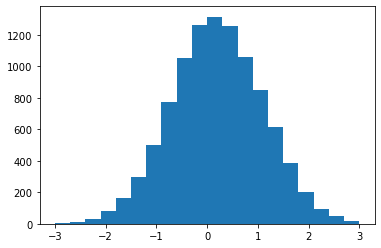

In [9]:
unfolded_hist,hist_bin_edges,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )

In [10]:
hist_bin_edges

array([-3. , -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3,  0. ,
        0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ])

In [11]:
hist_bin_centers = np.zeros( hist_nbins )
for bi in range(hist_nbins) :
    hist_bin_centers[bi] = 0.5*(hist_bin_edges[bi] + hist_bin_edges[bi+1])

In [12]:
hist_bin_centers

array([-2.85, -2.55, -2.25, -1.95, -1.65, -1.35, -1.05, -0.75, -0.45,
       -0.15,  0.15,  0.45,  0.75,  1.05,  1.35,  1.65,  1.95,  2.25,
        2.55,  2.85])

In [13]:
bin_width = hist_bin_edges[1] - hist_bin_edges[0]

In [14]:
weight_sum = np.sum( main_sample_omnifold_weights )
print('\n\n Sum of ominfold weights:  %.3f' % weight_sum )



 Sum of ominfold weights:  10008.232


In [15]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [16]:
mean_cov = calc_mean_cov( main_sample_omnifold_weights, 0, 0 )

In [17]:
mean_cov

{'mean_x1': 0.20167232670031057,
 'mean_x2': 0.20167232670031057,
 'cov_x1x2': 0.804728270056368,
 'rms1': 0.8970664802880376}

In [18]:
dummy_weights = np.ones( len(train_pts))
dummy_weights = (len(true_pts) / len(train_pts)) * dummy_weights

In [19]:
dummy_weights

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [20]:
dummy_weights.shape

(100000,)

<function matplotlib.pyplot.show(close=None, block=None)>

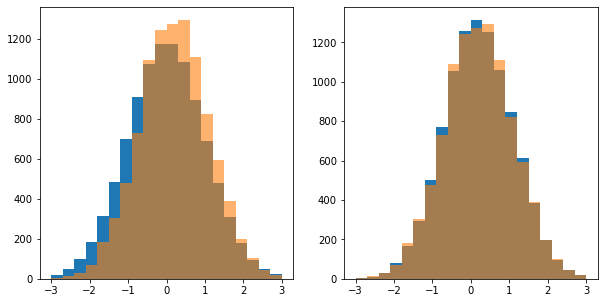

In [21]:
fig,ax = plt.subplots( 1, 2, figsize=(2*5,5))

ax[0].hist( train_pts[:,0], bins=hist_nbins, weights=dummy_weights, range=[hist_xlow, hist_xhigh] )
ax[0].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

ax[1].hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
ax[1].hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh], alpha=0.6 )

plt.show

In [22]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 500 bootstrap samples.




 Generating sample   0
 Generating sample   1
 Generating sample   2
 Generating sample   3
 Generating sample   4
 Generating sample   5
 Generating sample   6
 Generating sample   7
 Generating sample   8
 Generating sample   9
 Generating sample  10
 Generating sample  11
 Generating sample  12
 Generating sample  13
 Generating sample  14
 Generating sample  15
 Generating sample  16
 Generating sample  17
 Generating sample  18
 Generating sample  19
 Generating sample  20
 Generating sample  21
 Generating sample  22
 Generating sample  23
 Generating sample  24
 Generating sample  25
 Generating sample  26
 Generating sample  27
 Generating sample  28
 Generating sample  29
 Generating sample  30
 Generating sample  31
 Generating sample  32
 Generating sample  33
 Generating sample  34
 Generating sample  35
 Generating sample  36
 Generating sample  37
 Generating sample  38
 Generating sample  39
 Generating sample  40
 Generating sample  41
 Generating sample  42
 Generating

 Generating sample 371
 Generating sample 372
 Generating sample 373
 Generating sample 374
 Generating sample 375
 Generating sample 376
 Generating sample 377
 Generating sample 378
 Generating sample 379
 Generating sample 380
 Generating sample 381
 Generating sample 382
 Generating sample 383
 Generating sample 384
 Generating sample 385
 Generating sample 386
 Generating sample 387
 Generating sample 388
 Generating sample 389
 Generating sample 390
 Generating sample 391
 Generating sample 392
 Generating sample 393
 Generating sample 394
 Generating sample 395
 Generating sample 396
 Generating sample 397
 Generating sample 398
 Generating sample 399
 Generating sample 400
 Generating sample 401
 Generating sample 402
 Generating sample 403
 Generating sample 404
 Generating sample 405
 Generating sample 406
 Generating sample 407
 Generating sample 408
 Generating sample 409
 Generating sample 410
 Generating sample 411
 Generating sample 412
 Generating sample 413
 Generating

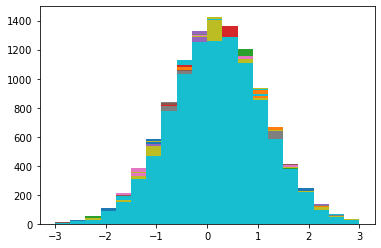

In [23]:
boot_hist_content = np.zeros( shape=(n_samples, hist_nbins))


simple_calc_mean = np.zeros( n_samples )
simple_calc_cov  = np.zeros( n_samples )

of_weight_sum = np.zeros( n_samples )


for bi in range(n_samples) :
    

        

            
    if generate_test_data :
            
        print(' Generating sample %3d' % bi )
            
        true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)
        hist_content,_,_ = plt.hist( true_pts[:,0], bins=hist_nbins, range=[hist_xlow, hist_xhigh] )
        boot_hist_content[bi,:] = hist_content
            
        x_mean = np.mean( true_pts[:,0] )
        x2_mean = np.mean( np.square( true_pts[:,0]) )
        x_cov = x2_mean - x_mean * x_mean
            
        simple_calc_mean[bi] = x_mean
        simple_calc_cov[bi] = x_cov
            
    else :
            
        fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)

        if not exists(fname) :  
            print('\n\n *** Missing %s' % fname )
            continue
            
        with open(fname,'rb') as f :            
            
            final_push_weights_scaled = np.load(f)
            print(' boot %3d weights: ' % bi, end='')
            print( final_push_weights_scaled)

            of_weight_sum[bi] = np.sum( final_push_weights_scaled )

            hist_content,_,_ = plt.hist( train_pts[:,0], bins=hist_nbins, weights=final_push_weights_scaled, range=[hist_xlow, hist_xhigh] )
            #print(hist_content)
            boot_hist_content[bi,:] = hist_content


            mean_cov = calc_mean_cov( final_push_weights_scaled, 0, 0 )

            simple_calc_mean[bi] = mean_cov['mean_x1']
            simple_calc_cov[bi]  = mean_cov['cov_x1x2']
    

In [24]:
boot_hist_content

array([[  3.,  19.,  33., ..., 114.,  40.,  20.],
       [  7.,  15.,  26., ..., 108.,  48.,  26.],
       [  6.,  14.,  38., ..., 107.,  49.,  13.],
       ...,
       [  4.,   7.,  36., ..., 105.,  58.,  23.],
       [  1.,  15.,  41., ..., 114.,  54.,  22.],
       [  8.,  16.,  27., ...,  92.,  50.,  24.]])

In [25]:
boot_hist_content[:,6]

array([520., 549., 531., 531., 494., 536., 481., 493., 522., 523., 518.,
       522., 533., 496., 522., 506., 519., 509., 484., 490., 517., 503.,
       510., 467., 490., 487., 495., 475., 489., 497., 536., 513., 540.,
       497., 506., 487., 547., 518., 550., 492., 505., 552., 507., 489.,
       507., 508., 531., 469., 499., 503., 512., 534., 513., 522., 529.,
       534., 493., 488., 492., 510., 495., 510., 503., 524., 526., 505.,
       506., 517., 532., 493., 496., 519., 460., 524., 539., 518., 526.,
       477., 474., 517., 492., 500., 472., 488., 498., 509., 536., 493.,
       524., 468., 450., 553., 528., 502., 501., 464., 553., 542., 514.,
       499., 480., 531., 475., 546., 509., 490., 481., 504., 519., 475.,
       499., 507., 522., 471., 517., 528., 531., 493., 519., 514., 510.,
       532., 502., 497., 493., 528., 509., 530., 515., 534., 517., 511.,
       527., 524., 463., 504., 516., 535., 519., 490., 493., 512., 539.,
       558., 526., 528., 507., 549., 526., 530., 51

In [26]:
hist_corr_mat = np.zeros( shape=(hist_nbins, hist_nbins) )
hist_cov_mat = np.zeros( shape=(hist_nbins, hist_nbins) )

for bi in range(hist_nbins) :
    
    for bj in range( hist_nbins ) :
        
        ccm = np.corrcoef( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        cvm =      np.cov( np.row_stack( ((boot_hist_content[:,bi], boot_hist_content[:,bj])) ) )
        
        hist_corr_mat[bi,bj] = ccm[0,1]
        
        hist_cov_mat[bi,bj] = cvm[0,1]
        
        if bi == bj : hist_cov_mat[bi,bj] = hist_cov_mat[bi,bj] + diagonal_constant
        

In [27]:
hist_corr_mat[0,hist_nbins-1] = -1.

<function matplotlib.pyplot.show(close=None, block=None)>

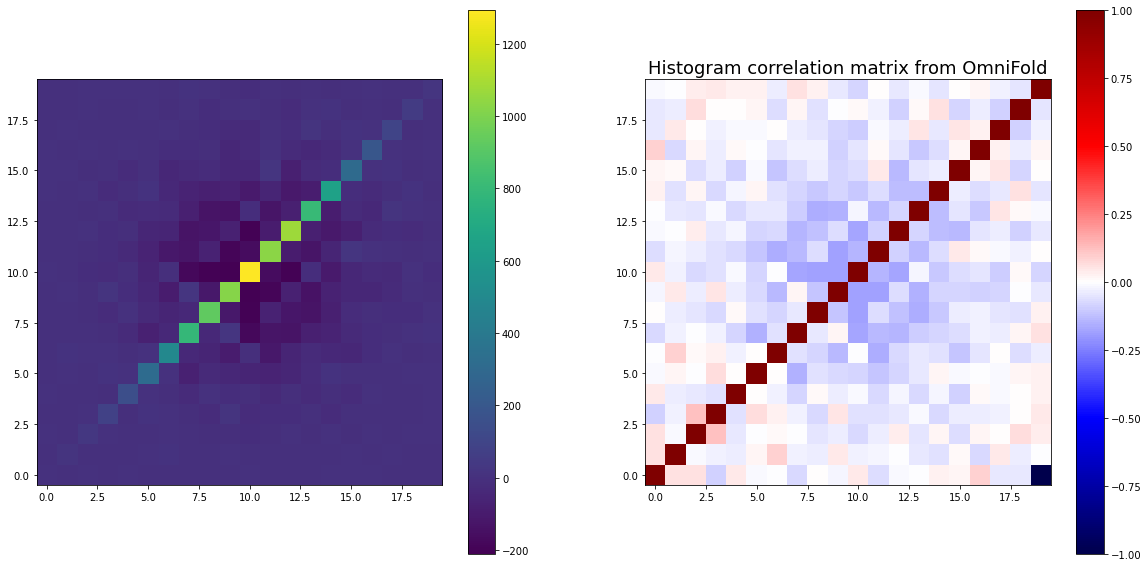

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [29]:
min_cov_element = np.min(hist_cov_mat)
max_cov_element = np.max(hist_cov_mat)
print('\n\n Min and max elements of cov mat:  %.2f , %.2f\n\n' % (min_cov_element, max_cov_element))
hist_cov_mat_copy = np.copy( hist_cov_mat )
hist_cov_mat_copy[0,hist_nbins-1] = -1. * max_cov_element



 Min and max elements of cov mat:  -210.81 , 1292.07




<function matplotlib.pyplot.show(close=None, block=None)>

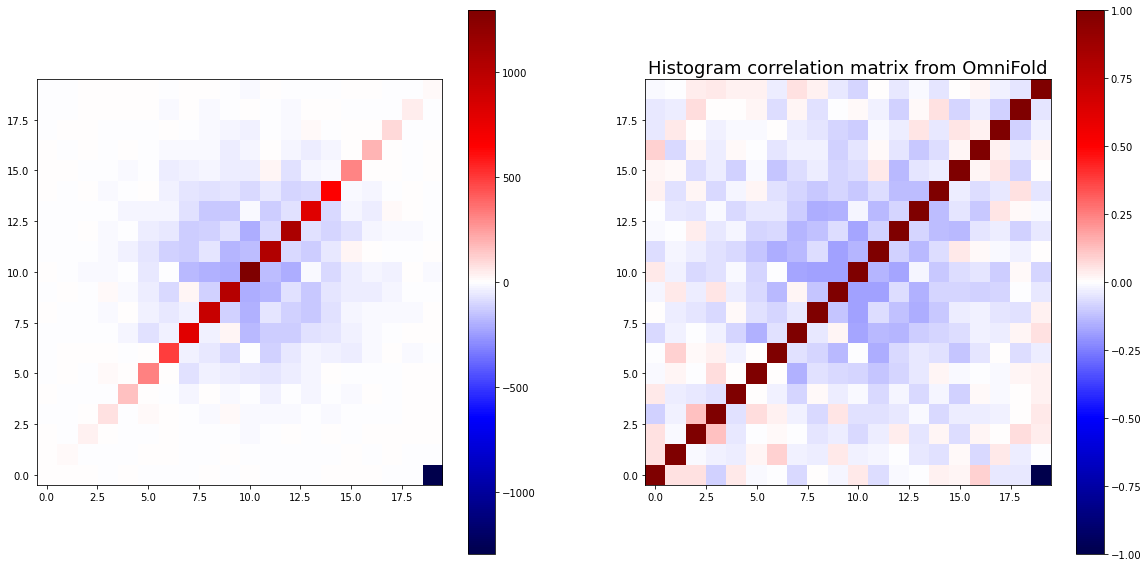

In [30]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_corr_mat, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )



ax[1].set_title('Histogram correlation matrix from OmniFold', fontsize=18)



plt.show

In [31]:
for bi in range(hist_nbins) :
    for bj in range(hist_nbins ) :
        
        calc_corr = hist_cov_mat[bi,bj] / np.sqrt( hist_cov_mat[bi,bi] * hist_cov_mat[bj,bj])
        
        print('  %2d, %2d :  histi  %10.2f   histj %10.2f  cov = %9.3f   cor = %9.4f  (%9.4f)' % 
              (bi, bj, boot_hist_content[0,bi], boot_hist_content[0,bj],
               hist_cov_mat[bi,bj], hist_corr_mat[bi,bj], calc_corr))



   0,  0 :  histi        3.00   histj       3.00  cov =     5.519   cor =    1.0000  (   1.0000)
   0,  1 :  histi        3.00   histj      19.00  cov =     0.449   cor =    0.0595  (   0.0518)
   0,  2 :  histi        3.00   histj      33.00  cov =     0.732   cor =    0.0601  (   0.0536)
   0,  3 :  histi        3.00   histj      74.00  cov =    -1.699   cor =   -0.0914  (  -0.0822)
   0,  4 :  histi        3.00   histj     170.00  cov =     1.154   cor =    0.0442  (   0.0399)
   0,  5 :  histi        3.00   histj     287.00  cov =    -0.304   cor =   -0.0081  (  -0.0073)
   0,  6 :  histi        3.00   histj     520.00  cov =    -0.186   cor =   -0.0040  (  -0.0036)
   0,  7 :  histi        3.00   histj     837.00  cov =    -4.531   cor =   -0.0759  (  -0.0687)
   0,  8 :  histi        3.00   histj    1063.00  cov =     0.488   cor =    0.0076  (   0.0068)
   0,  9 :  histi        3.00   histj    1182.00  cov =    -1.274   cor =   -0.0188  (  -0.0170)
   0, 10 :  histi        3.00 

In [32]:
print('      ', end='')
for bj in range( hist_nbins ) :
    print('   %2d   ' % bj, end='')
print()

for bi in range( hist_nbins ) :
    print(' %2d : ' % bi, end='')
    for bj in range( hist_nbins ) :
        print( ' %6.3f ' % hist_corr_mat[bi,bj], end='')
    print()

          0       1       2       3       4       5       6       7       8       9      10      11      12      13      14      15      16      17      18      19   
  0 :   1.000   0.060   0.060  -0.091   0.044  -0.008  -0.004  -0.076   0.008  -0.019   0.041  -0.069  -0.016  -0.003   0.028   0.021   0.087  -0.040  -0.042  -1.000 
  1 :   0.060   1.000  -0.013  -0.025  -0.033   0.016   0.088  -0.024  -0.034   0.040  -0.026  -0.016  -0.006  -0.041  -0.057   0.011  -0.074   0.041  -0.036  -0.002 
  2 :   0.060  -0.013   1.000   0.121  -0.047  -0.004   0.013  -0.000  -0.048  -0.038  -0.077  -0.033   0.034  -0.047   0.019  -0.065   0.020   0.004   0.066   0.034 
  3 :  -0.091  -0.025   0.121   1.000  -0.059   0.067   0.025  -0.026  -0.075   0.051  -0.062  -0.058  -0.041  -0.009  -0.078  -0.034  -0.033  -0.029   0.001   0.045 
  4 :   0.044  -0.033  -0.047  -0.059   1.000   0.004  -0.028  -0.080   0.008  -0.032  -0.012  -0.078  -0.022  -0.075  -0.023  -0.091   0.009  -0.011   0.001   0.027

In [33]:
cov_det = np.linalg.det( hist_cov_mat )
print('\n\n Histogram covariance matrix determinant:  %9.4f\n\n' % cov_det)



 Histogram covariance matrix determinant:  85396655045924259571689231115801122800926720.0000




In [34]:
hist_cov_inv = np.linalg.inv( hist_cov_mat )
print(hist_cov_inv)

[[0.21217491 0.01985372 0.02135032 0.03144609 0.02616352 0.02798315
  0.02782667 0.02841227 0.02756966 0.02793767 0.02716831 0.02873087
  0.02782145 0.02757975 0.02760488 0.02693072 0.02453346 0.02939166
  0.02904583 0.02759073]
 [0.01985372 0.10566315 0.03020212 0.03134834 0.03116671 0.03039804
  0.02960437 0.03067038 0.0310404  0.03058395 0.03072759 0.03091944
  0.03070561 0.0312519  0.03177368 0.03032256 0.03169885 0.02913943
  0.02998727 0.02922265]
 [0.02135032 0.03020212 0.06010906 0.02749576 0.03077673 0.03053908
  0.03024523 0.03012327 0.03064598 0.03088821 0.03053041 0.03071451
  0.03010996 0.03076166 0.03065954 0.03075893 0.02957951 0.02970412
  0.0270695  0.02796002]
 [0.03144609 0.03134834 0.02749576 0.04415822 0.0312195  0.03057687
  0.0308355  0.03091383 0.0313047  0.03107007 0.03100657 0.0313735
  0.03111119 0.03113312 0.0318227  0.03096285 0.03066583 0.0310074
  0.02969179 0.0288062 ]
 [0.02616352 0.03116671 0.03077673 0.0312195  0.03758752 0.03112566
  0.03120261 0.031

In [35]:
cov_inv_test = np.matmul( hist_cov_mat, hist_cov_inv )
print( cov_inv_test)

[[ 1.00000000e+00  4.23556435e-17 -1.76889403e-17 -1.32139156e-17
   5.13591346e-17  2.57045097e-17  2.80592748e-17 -2.91564847e-17
   8.90624060e-17  4.34533031e-17  7.83786374e-18 -1.58496032e-17
  -1.91331835e-17 -2.78518055e-17 -6.55691297e-17  5.09622491e-17
   3.53945335e-17  1.38221804e-17  7.95058737e-17 -3.15433598e-17]
 [-3.10244542e-17  1.00000000e+00  1.35882872e-16 -1.42411645e-16
   4.15775149e-17 -5.52749943e-17 -2.15704674e-17 -1.01127561e-16
   1.38929333e-16 -5.41118278e-17  4.20671539e-17 -5.05311553e-17
  -1.05858911e-16  5.21188903e-17 -9.93656651e-17  1.42108304e-16
   8.77447963e-17 -1.42613365e-16  7.39230320e-17 -7.53833097e-17]
 [ 3.91131169e-16  3.26245934e-16  1.00000000e+00  4.35312845e-16
   9.74439821e-17  3.84155875e-16  1.34557196e-16  1.19810585e-16
   2.01278885e-16  9.11248452e-17 -2.62589370e-16  1.01339681e-17
  -3.38229578e-16  6.00594309e-16  1.25557695e-16  3.09544481e-16
   3.96487004e-17  2.09492684e-16  7.97407979e-17  2.19491613e-16]
 [-1.07

<function matplotlib.pyplot.show(close=None, block=None)>

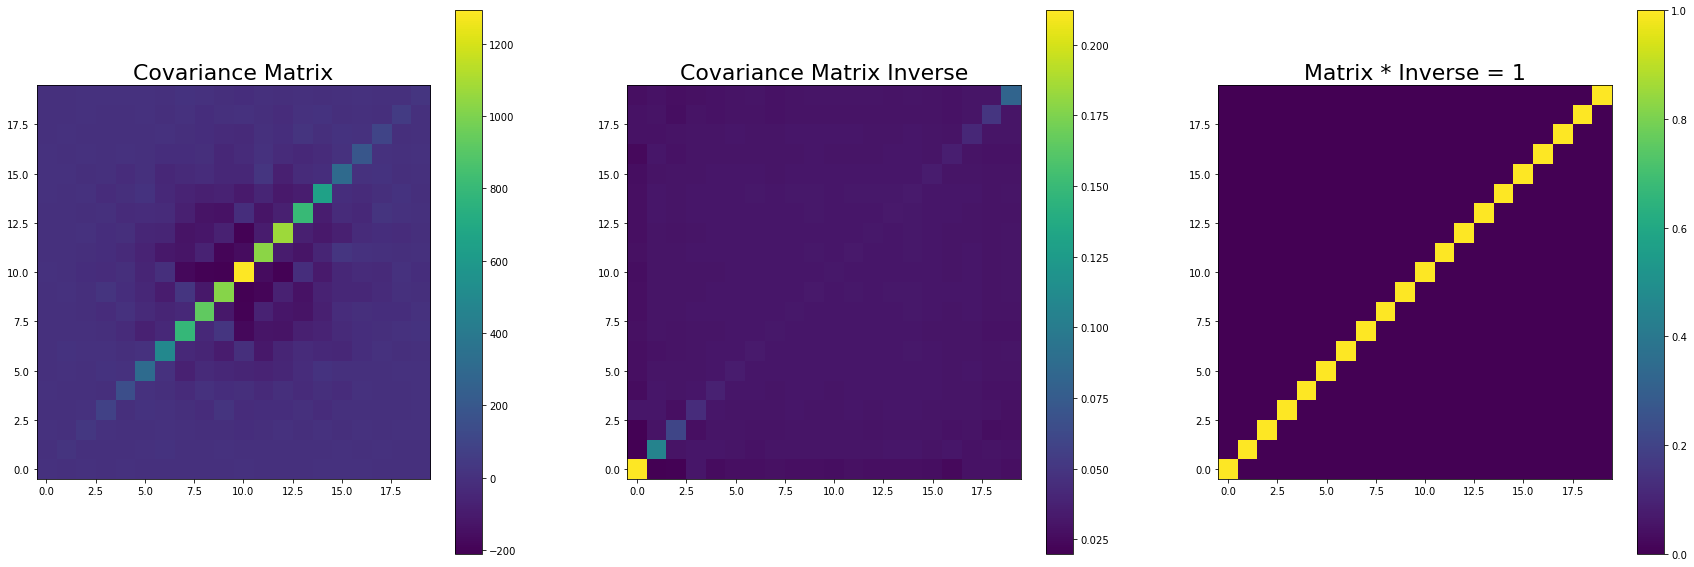

In [36]:
fig,ax = plt.subplots( 1, 3, figsize=(3*10,10))


im_covmat = ax[0].imshow(hist_cov_mat, origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im_covinv = ax[1].imshow(hist_cov_inv, origin='lower')
ax[1].figure.colorbar( im_covinv, ax=ax[1] )

im_covtest = ax[2].imshow(cov_inv_test, origin='lower')
ax[2].figure.colorbar( im_covtest, ax=ax[2] )

ax[0].set_title('Covariance Matrix', fontsize='22')
ax[1].set_title('Covariance Matrix Inverse', fontsize='22')
ax[2].set_title('Matrix * Inverse = 1', fontsize='22')

plt.show



In [37]:
ci_min = np.min(hist_cov_inv)
ci_max = np.max(hist_cov_inv)
print('\n\n min and max of covariance matrix inverse:  %.2f  %.2f\n\n' % (ci_min, ci_max))

hist_cov_inv_copy = np.copy( hist_cov_inv )
hist_cov_inv_copy[0,hist_nbins-1] = -1. * ci_max




 min and max of covariance matrix inverse:  0.02  0.21




<function matplotlib.pyplot.show(close=None, block=None)>

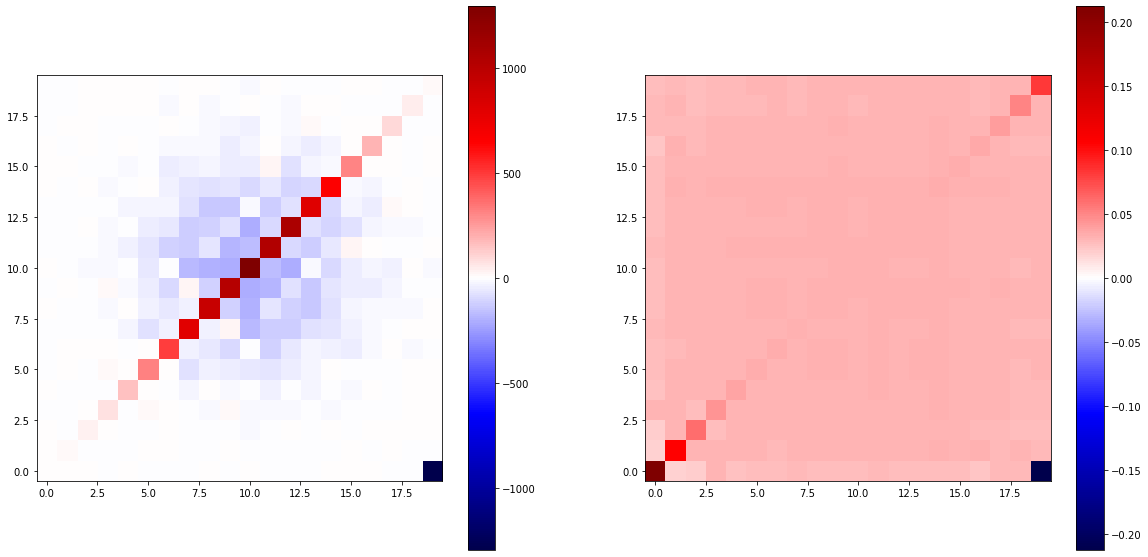

In [38]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_mat_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [39]:
cov_mat_evals = np.linalg.eigvals( hist_cov_mat )

In [40]:
cov_mat_evals

array([1520.81296769, 1242.72957672, 1176.94471382, 1014.54916666,
        918.25194972,  799.40458906,  754.25600811,  538.68663612,
        375.26640287,  304.87402531,  205.79635269,  157.0033642 ,
         99.59942487,   83.37541634,   50.75992469,    1.58009272,
          5.5398352 ,   33.10452759,   14.04197316,   20.01051539])

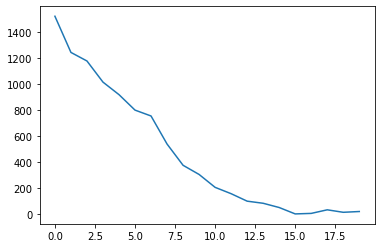

In [41]:
plt.plot(cov_mat_evals)

In [42]:
U, S, Vh = np.linalg.svd( hist_cov_mat, full_matrices=True)

In [43]:
U.shape

(20, 20)

In [44]:
S.shape

(20,)

In [45]:
Vh.shape

(20, 20)

In [46]:
S

array([1520.81296769, 1242.72957672, 1176.94471382, 1014.54916666,
        918.25194972,  799.40458906,  754.25600811,  538.68663612,
        375.26640287,  304.87402531,  205.79635269,  157.0033642 ,
         99.59942487,   83.37541634,   50.75992469,   33.10452759,
         20.01051539,   14.04197316,    5.5398352 ,    1.58009272])

In [47]:
U

array([[-2.90908132e-03, -1.54759495e-03, -5.80456565e-04,
         2.72340774e-03,  1.58108233e-03, -3.54166471e-03,
        -4.49765134e-03, -4.70211663e-04,  3.69048868e-03,
        -4.44867748e-03, -1.52634308e-02, -1.35372450e-03,
        -1.12528697e-02, -1.29354622e-02,  3.26657952e-03,
        -4.89515568e-02,  1.30406335e-02,  8.71276490e-02,
        -9.57235333e-01, -2.70029691e-01],
       [ 1.76845769e-03, -3.32308271e-03, -6.59492893e-04,
        -3.21495542e-03,  2.00086302e-03, -1.28247899e-03,
         1.06874740e-03,  1.87192957e-02,  2.75534961e-03,
        -4.05226036e-03,  1.61403851e-02, -4.21501250e-03,
         2.61412717e-02, -1.01993163e-02,  1.35609312e-02,
        -3.32203943e-02,  1.33713890e-01,  9.47223450e-01,
         1.57007258e-01, -2.39745141e-01],
       [ 8.05426943e-03,  2.68159164e-05, -7.66064195e-03,
         1.15380728e-03, -4.24914349e-03,  1.02408171e-02,
        -1.28584436e-02,  9.92649614e-03,  2.67838227e-03,
         1.22484450e-02, -2.6

In [48]:
U[:,0]

array([-2.90908132e-03,  1.76845769e-03,  8.05426943e-03,  7.72412523e-03,
       -3.35452063e-03, -5.65481641e-04, -6.08199473e-02,  1.62035053e-01,
        1.98257986e-01,  2.94639739e-01, -8.67732575e-01,  1.03841669e-01,
        2.45905362e-01, -1.36508642e-01,  2.72562412e-02,  3.24355717e-03,
        5.64310370e-03,  7.50627893e-03, -6.97116426e-03,  6.47265055e-03])

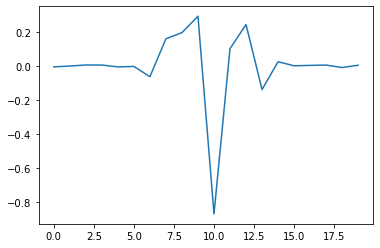

In [49]:
plt.plot(U[:,0])

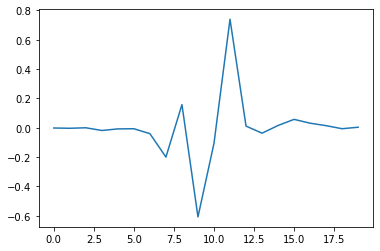

In [50]:
plt.plot(U[:,1])

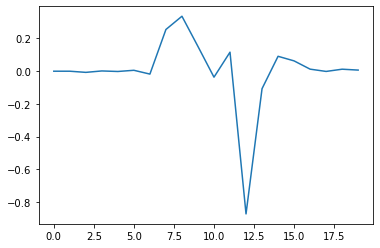

In [51]:
plt.plot(U[:,2])

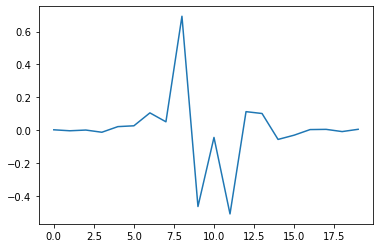

In [52]:
plt.plot(U[:,3])

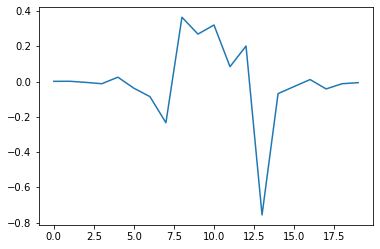

In [53]:
plt.plot(U[:,4])

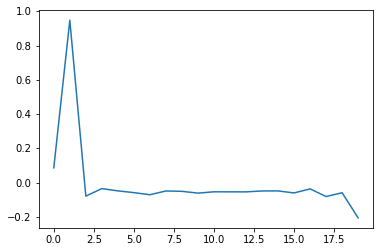

In [54]:
plt.plot(U[:,17])

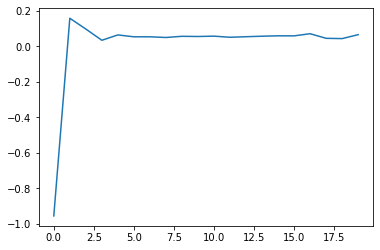

In [55]:
plt.plot(U[:,18])

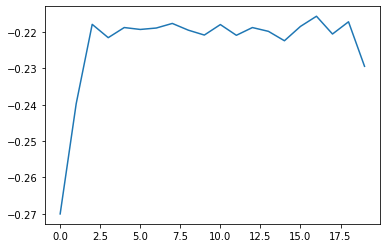

In [56]:
plt.plot(U[:,19])

(-50.0, 50.0)

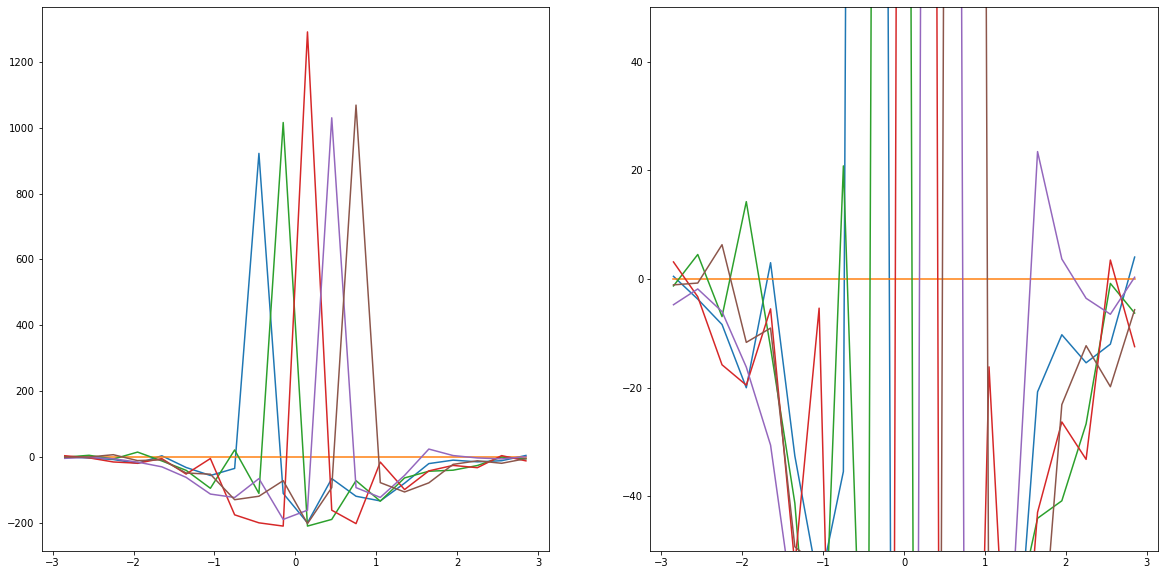

In [57]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[0].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[0].plot( hist_bin_centers, hist_cov_mat[12,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[8,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[9,:] )
if hist_nbins >= 13 :
    ax[1].plot( hist_bin_centers, hist_cov_mat[10,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[11,:] )
    ax[1].plot( hist_bin_centers, hist_cov_mat[12,:] )


ax[1].set_ylim([-50,50])

(-50.0, 50.0)

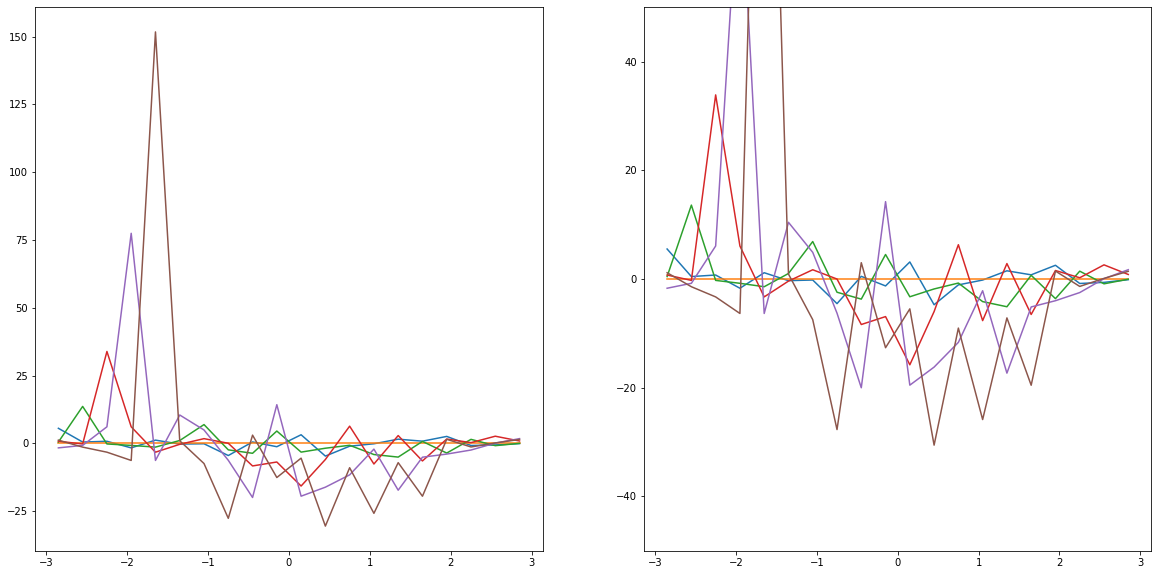

In [58]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))

ax[0].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[0].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[0].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[0].plot( hist_bin_centers, hist_cov_mat[4,:] )

ax[1].plot( hist_bin_centers, hist_cov_mat[0,:] )
ax[1].plot( hist_bin_centers, np.zeros(hist_nbins))
ax[1].plot( hist_bin_centers, hist_cov_mat[1,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[2,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[3,:] )
ax[1].plot( hist_bin_centers, hist_cov_mat[4,:] )


ax[1].set_ylim([-50,50])

## Try using the pseudo inverse of the covariance matrix for the chi2

In [59]:

#--- off
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat )


#--- not enough?
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.0001 )

#--- ok
hist_cov_pinv = np.linalg.pinv( hist_cov_mat, rcond_val )
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.01 )

#-- probably too much
#hist_cov_pinv = np.linalg.pinv( hist_cov_mat, 0.05 )


print(hist_cov_pinv)

[[0.21217491 0.01985372 0.02135032 0.03144609 0.02616352 0.02798315
  0.02782667 0.02841227 0.02756966 0.02793767 0.02716831 0.02873087
  0.02782145 0.02757975 0.02760488 0.02693072 0.02453346 0.02939166
  0.02904583 0.02759073]
 [0.01985372 0.10566315 0.03020212 0.03134834 0.03116671 0.03039804
  0.02960437 0.03067038 0.0310404  0.03058395 0.03072759 0.03091944
  0.03070561 0.0312519  0.03177368 0.03032256 0.03169885 0.02913943
  0.02998727 0.02922265]
 [0.02135032 0.03020212 0.06010906 0.02749576 0.03077673 0.03053908
  0.03024523 0.03012327 0.03064598 0.03088821 0.03053041 0.03071451
  0.03010996 0.03076166 0.03065954 0.03075893 0.02957951 0.02970412
  0.0270695  0.02796002]
 [0.03144609 0.03134834 0.02749576 0.04415822 0.0312195  0.03057687
  0.0308355  0.03091383 0.0313047  0.03107007 0.03100657 0.0313735
  0.03111119 0.03113312 0.0318227  0.03096285 0.03066583 0.0310074
  0.02969179 0.0288062 ]
 [0.02616352 0.03116671 0.03077673 0.0312195  0.03758752 0.03112566
  0.03120261 0.031

In [60]:
hist_cov_pinv_minus_inv = hist_cov_pinv - hist_cov_inv

In [61]:
cov_pinv_test = np.matmul( hist_cov_mat, hist_cov_pinv )

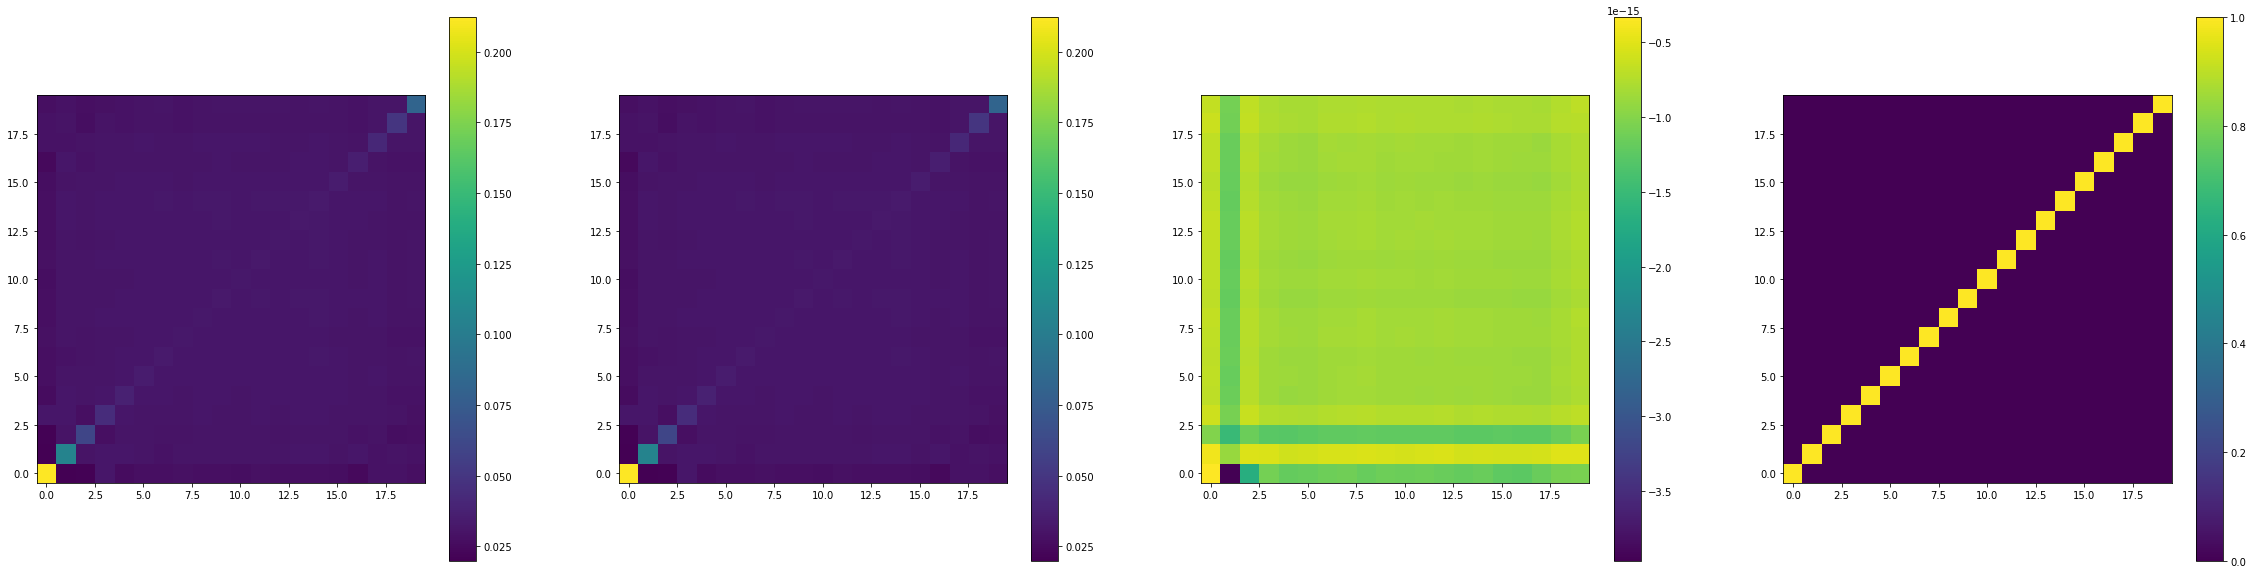

In [62]:
fig,ax = plt.subplots( 1, 4, figsize=(4*10,10))



im_covinv = ax[0].imshow(hist_cov_inv, origin='lower')
ax[0].figure.colorbar( im_covinv, ax=ax[0] )

im_covpinv = ax[1].imshow(hist_cov_pinv, origin='lower')
ax[1].figure.colorbar( im_covpinv, ax=ax[1] )

im_covpinvdiff = ax[2].imshow(hist_cov_pinv_minus_inv, origin='lower')
ax[2].figure.colorbar( im_covpinvdiff, ax=ax[2] )

im_pinv_test = ax[3].imshow(cov_pinv_test, origin='lower')
ax[3].figure.colorbar( im_pinv_test, ax=ax[3] )



In [63]:
cpi_min = np.min(hist_cov_pinv)
cpi_max = np.max(hist_cov_pinv)
print('\n\n min and max of covariance matrix pseudo inverse:  %.2f  %.2f\n\n' % (cpi_min, cpi_max))

hist_cov_pinv_copy = np.copy( hist_cov_pinv )
hist_cov_pinv_copy[0,hist_nbins-1] = -1. * cpi_max




 min and max of covariance matrix pseudo inverse:  0.02  0.21




In [64]:
for bi in range( hist_nbins ) :
    print('bin %3d : x = %7.2f  diagonal,  cov inv %10.5f,  cov pinv %10.5f  ' %(
    bi, hist_bin_centers[bi], hist_cov_inv[bi,bi], hist_cov_pinv[bi,bi]))

bin   0 : x =   -2.85  diagonal,  cov inv    0.21217,  cov pinv    0.21217  
bin   1 : x =   -2.55  diagonal,  cov inv    0.10566,  cov pinv    0.10566  
bin   2 : x =   -2.25  diagonal,  cov inv    0.06011,  cov pinv    0.06011  
bin   3 : x =   -1.95  diagonal,  cov inv    0.04416,  cov pinv    0.04416  
bin   4 : x =   -1.65  diagonal,  cov inv    0.03759,  cov pinv    0.03759  
bin   5 : x =   -1.35  diagonal,  cov inv    0.03469,  cov pinv    0.03469  
bin   6 : x =   -1.05  diagonal,  cov inv    0.03346,  cov pinv    0.03346  
bin   7 : x =   -0.75  diagonal,  cov inv    0.03223,  cov pinv    0.03223  
bin   8 : x =   -0.45  diagonal,  cov inv    0.03262,  cov pinv    0.03262  
bin   9 : x =   -0.15  diagonal,  cov inv    0.03297,  cov pinv    0.03297  
bin  10 : x =    0.15  diagonal,  cov inv    0.03191,  cov pinv    0.03191  
bin  11 : x =    0.45  diagonal,  cov inv    0.03286,  cov pinv    0.03286  
bin  12 : x =    0.75  diagonal,  cov inv    0.03224,  cov pinv    0.03224  

<function matplotlib.pyplot.show(close=None, block=None)>

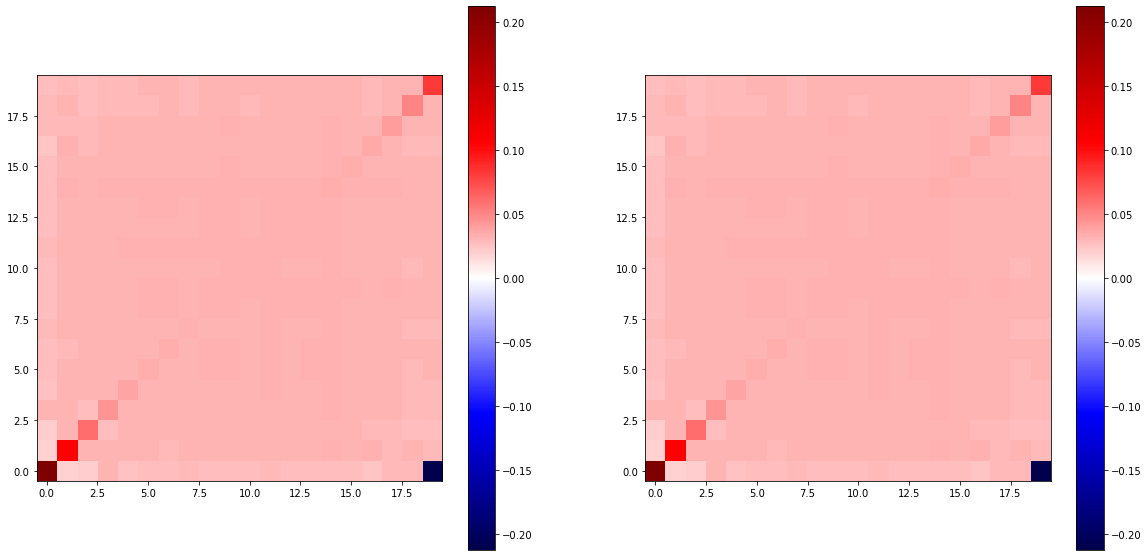

In [65]:
fig,ax = plt.subplots( 1, 2, figsize=(2*10,10))


im_covmat = ax[0].imshow(hist_cov_inv_copy, cmap='seismic', origin='lower')
ax[0].figure.colorbar( im_covmat, ax=ax[0] )

im = ax[1].imshow(hist_cov_pinv_copy, cmap='seismic', origin='lower')
ax[1].figure.colorbar( im, ax=ax[1] )







plt.show

In [66]:
hist_cov_inv[:,10]

array([0.02716831, 0.03072759, 0.03053041, 0.03100657, 0.03100757,
       0.03139545, 0.03123562, 0.03115396, 0.03145687, 0.03165455,
       0.03190619, 0.03158386, 0.03132349, 0.03138251, 0.03182428,
       0.03116634, 0.03077683, 0.03116105, 0.02969998, 0.0305282 ])

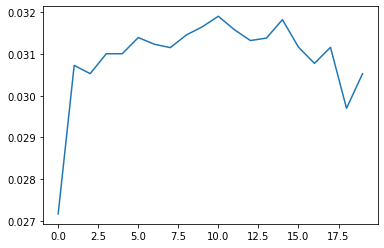

In [67]:
plt.plot(hist_cov_inv[:,10])
#plt.plot(hist_cov_inv[:,11])
#plt.plot(hist_cov_inv[:,12])

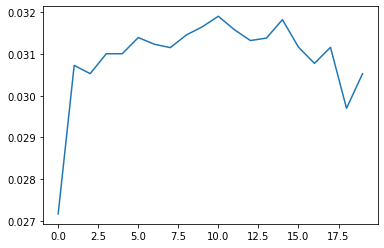

In [68]:
plt.plot(hist_cov_pinv[:,10])
#plt.plot(hist_cov_pinv[:,11])
#plt.plot(hist_cov_pinv[:,12])

In [69]:
for bi in range( hist_nbins ) :
    for bj in range( hist_nbins ) :
        print('  %3d, %3d:   inv = %8.3f   pinv = %8.3f' % (bi, bj, hist_cov_inv[bi,bj], hist_cov_pinv[bi,bj]))

    0,   0:   inv =    0.212   pinv =    0.212
    0,   1:   inv =    0.020   pinv =    0.020
    0,   2:   inv =    0.021   pinv =    0.021
    0,   3:   inv =    0.031   pinv =    0.031
    0,   4:   inv =    0.026   pinv =    0.026
    0,   5:   inv =    0.028   pinv =    0.028
    0,   6:   inv =    0.028   pinv =    0.028
    0,   7:   inv =    0.028   pinv =    0.028
    0,   8:   inv =    0.028   pinv =    0.028
    0,   9:   inv =    0.028   pinv =    0.028
    0,  10:   inv =    0.027   pinv =    0.027
    0,  11:   inv =    0.029   pinv =    0.029
    0,  12:   inv =    0.028   pinv =    0.028
    0,  13:   inv =    0.028   pinv =    0.028
    0,  14:   inv =    0.028   pinv =    0.028
    0,  15:   inv =    0.027   pinv =    0.027
    0,  16:   inv =    0.025   pinv =    0.025
    0,  17:   inv =    0.029   pinv =    0.029
    0,  18:   inv =    0.029   pinv =    0.029
    0,  19:   inv =    0.028   pinv =    0.028
    1,   0:   inv =    0.020   pinv =    0.020
    1,   1:  

In [70]:
hist_cov_mat_diagonal = np.copy( hist_cov_mat )
for bi in range(hist_nbins) :
    for bj in range(hist_nbins) :
        if bi != bj : hist_cov_mat_diagonal[bi,bj] = 0.

In [71]:
hist_cov_mat_diagonal

array([[   5.51863727,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,   13.59502605,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,   33.86741082,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.   

In [72]:
hist_cov_inv_diagonal = np.linalg.inv( hist_cov_mat_diagonal )
print(hist_cov_inv_diagonal)

[[0.18120415 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.07355631 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.02952691 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.01290842 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.00658868 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [73]:
diagonal_hist_sigma2 = np.zeros( shape=(hist_nbins) )
for bi in range( hist_nbins ) :
    diagonal_hist_sigma2[bi] = hist_cov_mat_diagonal[bi,bi]
diagonal_hist_sigma = np.sqrt( diagonal_hist_sigma2 )

In [74]:
diagonal_hist_sigma

array([ 2.349178  ,  3.68714335,  5.81957136,  8.80163744, 12.31971797,
       17.75404213, 22.13061826, 28.08198732, 30.37524834, 31.88279884,
       35.9453091 , 32.10667565, 32.70276633, 28.27061831, 25.46061566,
       17.54393237, 13.75888214,  9.83482749,  6.96362579,  4.41218026])

In [75]:
sqrtn_from_hist = np.sqrt( unfolded_hist )

In [76]:
sqrtn_from_hist

array([ 1.52554736,  2.92185538,  5.34195904,  8.8738936 , 12.87529487,
       17.19912126, 22.4046461 , 27.75008963, 32.44730503, 35.49223873,
       36.25103748, 35.3906292 , 32.55920976, 29.13428734, 24.73833659,
       19.65310282, 14.11345239,  9.70530896,  6.83954457,  4.31308854])

In [77]:
err_ratio = diagonal_hist_sigma / sqrtn_from_hist

In [78]:
err_ratio

array([1.53989189, 1.2619185 , 1.08940771, 0.99185745, 0.95684938,
       1.03226449, 0.98776915, 1.01196024, 0.93614087, 0.8983034 ,
       0.99156636, 0.90720839, 1.00440909, 0.97035558, 1.02919675,
       0.89268003, 0.97487714, 1.01334512, 1.01814174, 1.02297466])

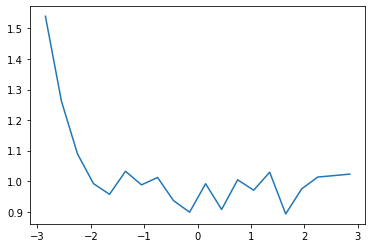

In [79]:
plt.plot( hist_bin_centers, err_ratio )

<ErrorbarContainer object of 3 artists>

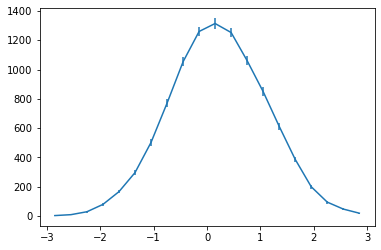

In [80]:
plt.errorbar( hist_bin_centers, unfolded_hist, diagonal_hist_sigma )

In [81]:
boot_hist_content

array([[  3.,  19.,  33., ..., 114.,  40.,  20.],
       [  7.,  15.,  26., ..., 108.,  48.,  26.],
       [  6.,  14.,  38., ..., 107.,  49.,  13.],
       ...,
       [  4.,   7.,  36., ..., 105.,  58.,  23.],
       [  1.,  15.,  41., ..., 114.,  54.,  22.],
       [  8.,  16.,  27., ...,  92.,  50.,  24.]])

In [82]:
np.sum(boot_hist_content, axis=1)

array([9994., 9987., 9986., 9992., 9992., 9993., 9991., 9993., 9992.,
       9992., 9991., 9991., 9993., 9989., 9982., 9992., 9988., 9983.,
       9986., 9988., 9987., 9990., 9995., 9991., 9993., 9981., 9986.,
       9989., 9994., 9991., 9984., 9990., 9986., 9983., 9996., 9991.,
       9995., 9984., 9984., 9984., 9992., 9983., 9993., 9986., 9985.,
       9984., 9983., 9984., 9987., 9990., 9987., 9985., 9985., 9992.,
       9989., 9990., 9989., 9988., 9989., 9989., 9986., 9983., 9993.,
       9990., 9990., 9990., 9990., 9989., 9990., 9990., 9983., 9989.,
       9990., 9994., 9988., 9988., 9990., 9984., 9989., 9995., 9989.,
       9984., 9994., 9985., 9984., 9987., 9989., 9990., 9988., 9990.,
       9985., 9993., 9984., 9986., 9982., 9988., 9988., 9984., 9987.,
       9988., 9986., 9989., 9993., 9983., 9991., 9989., 9989., 9993.,
       9989., 9989., 9991., 9989., 9984., 9989., 9989., 9990., 9990.,
       9991., 9985., 9985., 9991., 9985., 9993., 9990., 9992., 9995.,
       9986., 9988.,

(array([ 13.,  33.,  48.,  38.,  79., 131.,  51.,  70.,  29.,   8.]),
 array([9980. , 9981.7, 9983.4, 9985.1, 9986.8, 9988.5, 9990.2, 9991.9,
        9993.6, 9995.3, 9997. ]),
 <BarContainer object of 10 artists>)

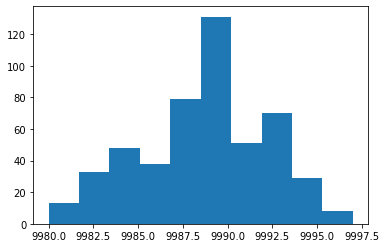

In [83]:
plt.hist(np.sum(boot_hist_content, axis=1))

(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

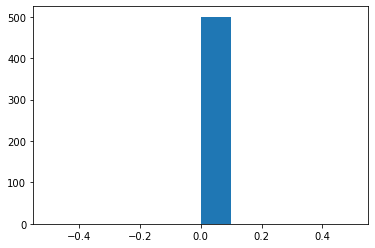

In [84]:
plt.hist(of_weight_sum)

In [85]:
model_mu = 0.2
model_sigma = 0.90
model_cov = model_sigma * model_sigma

hist_sum = np.sum( unfolded_hist )

model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt(  2 * 3.14159265 ) )

model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )




<function matplotlib.pyplot.show(close=None, block=None)>

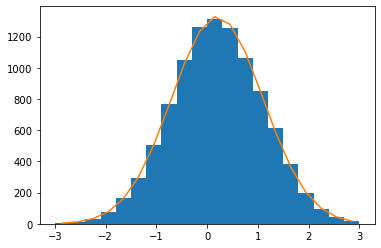

In [86]:

plt.hist( train_pts[:,0], bins=hist_nbins, weights=main_sample_omnifold_weights, range=[hist_xlow, hist_xhigh] )
plt.plot( hist_bin_centers, model_pred )



plt.show

In [87]:
weight_sum

10008.232063478768

In [88]:
np.sum(unfolded_hist)

9996.829894763836

In [89]:
for bi in range( hist_nbins ) :
    diff = unfolded_hist[bi] - model_pred[bi]
    print(' %3d : x = %5.2f  model = %8.1f  hist = %8.1f  diff = %8.1f   sqrt(covii) = %8.1f' % 
          (bi, hist_bin_centers[bi], model_pred[bi], unfolded_hist[bi], diff, np.sqrt(hist_cov_mat[bi,bi]) ))

   0 : x = -2.85  model =      4.3  hist =      2.3  diff =     -1.9   sqrt(covii) =      2.3
   1 : x = -2.55  model =     12.5  hist =      8.5  diff =     -3.9   sqrt(covii) =      3.7
   2 : x = -2.25  model =     32.7  hist =     28.5  diff =     -4.2   sqrt(covii) =      5.8
   3 : x = -1.95  model =     76.6  hist =     78.7  diff =      2.1   sqrt(covii) =      8.8
   4 : x = -1.65  model =    160.7  hist =    165.8  diff =      5.0   sqrt(covii) =     12.3
   5 : x = -1.35  model =    301.7  hist =    295.8  diff =     -5.9   sqrt(covii) =     17.8
   6 : x = -1.05  model =    506.7  hist =    502.0  diff =     -4.8   sqrt(covii) =     22.1
   7 : x = -0.75  model =    761.6  hist =    770.1  diff =      8.5   sqrt(covii) =     28.1
   8 : x = -0.45  model =   1024.2  hist =   1052.8  diff =     28.6   sqrt(covii) =     30.4
   9 : x = -0.15  model =   1232.6  hist =   1259.7  diff =     27.1   sqrt(covii) =     31.9
  10 : x =  0.15  model =   1327.3  hist =   1314.1  diff = 

In [90]:
dy = unfolded_hist - model_pred
    
cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)

cov_pinv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
dy_times_cov_pinv_times_dy =  np.sum( dy.T * cov_pinv_times_dy, axis=0)
    
this_chi2 = dy_times_cov_inv_times_dy

this_chi2_pinv = dy_times_cov_pinv_times_dy

print('\n\n chi2 = %10.3f, with pseudoinverse = %10.3f\n\n' % (this_chi2, this_chi2_pinv) )



 chi2 =     13.339, with pseudoinverse =     13.339




In [91]:
cov_inv_diagonal_times_dy = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )


In [92]:
dy

array([ -1.93662362,  -3.94444917,  -4.15858531,   2.10918391,
         5.02839303,  -5.89464849,  -4.75575224,   8.50384699,
        28.62461103,  27.13085073, -13.19838108, -26.57811387,
       -42.84830951,  -2.25517737,  24.34532676,  23.16089639,
        -1.55645441,  -5.12595767,   2.80874158,   1.18313382])

In [93]:
cov_inv_times_dy

array([-0.04396627,  0.08357174,  0.24067607,  0.38257933,  0.39004297,
        0.32917872,  0.35902521,  0.35354324,  0.38469762,  0.38318814,
        0.34614251,  0.33211264,  0.32498055,  0.36024085,  0.39694559,
        0.43368047,  0.34802618,  0.3026829 ,  0.3894892 ,  0.40008757])

<function matplotlib.pyplot.show(close=None, block=None)>

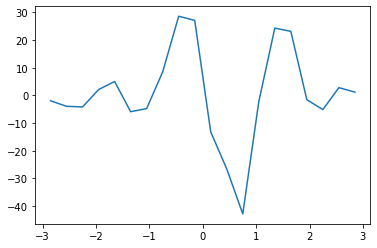

In [94]:
plt.plot( hist_bin_centers, dy )
plt.show

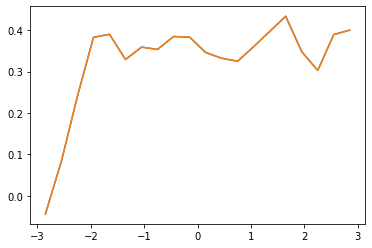

In [95]:
plt.plot( hist_bin_centers, cov_inv_times_dy )
plt.plot( hist_bin_centers, cov_pinv_times_dy )

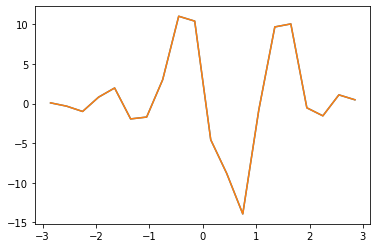

In [96]:
plt.plot( hist_bin_centers, dy.T * cov_inv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

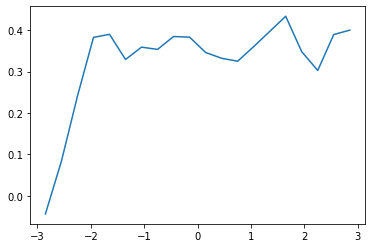

In [97]:
plt.plot( hist_bin_centers, cov_pinv_times_dy )

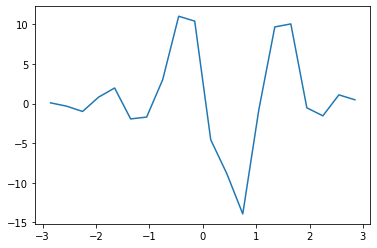

In [98]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )

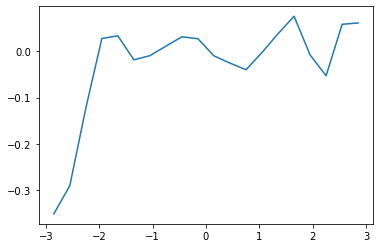

In [99]:
plt.plot( hist_bin_centers, cov_inv_diagonal_times_dy )

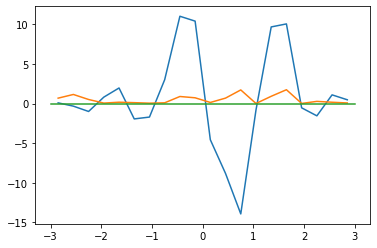

In [100]:
plt.plot( hist_bin_centers, dy.T * cov_pinv_times_dy )
plt.plot( hist_bin_centers, dy.T * cov_inv_diagonal_times_dy )
plt.plot( [-3,3], [0,0])

In [101]:
n_scan_points = 10

scan_min = 0.0
scan_max = 0.4

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.000  chi2 =          496.19,   diagonal chi2 =          526.20
 scan point   1  par   0.044  chi2 =          305.44,   diagonal chi2 =          320.54
 scan point   2  par   0.089  chi2 =          163.46,   diagonal chi2 =          168.32
 scan point   3  par   0.133  chi2 =           68.70,   diagonal chi2 =           67.55
 scan point   4  par   0.178  chi2 =           20.26,   diagonal chi2 =           16.91
 scan point   5  par   0.222  chi2 =           17.98,   diagonal chi2 =           15.68
 scan point   6  par   0.267  chi2 =           62.33,   diagonal chi2 =           63.77
 scan point   7  par   0.311  chi2 =          154.46,   diagonal chi2 =          161.65
 scan point   8  par   0.356  chi2 =          296.19,   diagonal chi2 =          310.38
 scan point   9  par   0.400  chi2 =          490.01,   diagonal chi2 =          511.59


<function matplotlib.pyplot.show(close=None, block=None)>

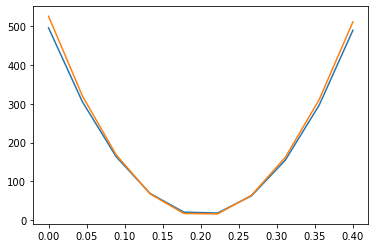

In [102]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [103]:
n_scan_points = 10

scan_min = 0.7
scan_max = 0.9

#scan_min = 0.78
#scan_max = 0.84

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )


for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_sigma = np.sqrt( scan_par_vals[si] )
    model_cov = scan_par_vals[si]

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )

    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy
    
    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
     
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.700  chi2 =          103.05,   diagonal chi2 =          108.75
 scan point   1  par   0.722  chi2 =           69.20,   diagonal chi2 =           72.67
 scan point   2  par   0.744  chi2 =           43.55,   diagonal chi2 =           45.08
 scan point   3  par   0.767  chi2 =           25.84,   diagonal chi2 =           25.66
 scan point   4  par   0.789  chi2 =           15.85,   diagonal chi2 =           14.10
 scan point   5  par   0.811  chi2 =           13.39,   diagonal chi2 =           10.12
 scan point   6  par   0.833  chi2 =           18.33,   diagonal chi2 =           13.47
 scan point   7  par   0.856  chi2 =           30.55,   diagonal chi2 =           23.94
 scan point   8  par   0.878  chi2 =           49.97,   diagonal chi2 =           41.31
 scan point   9  par   0.900  chi2 =           76.51,   diagonal chi2 =           65.39


<function matplotlib.pyplot.show(close=None, block=None)>

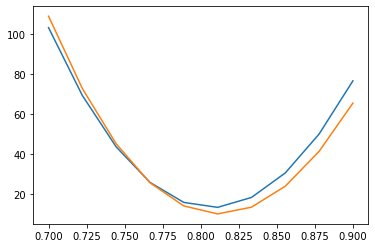

In [104]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

## Set up a Minuit fit

Used this example from Glen Cowan as a starting point: https://github.com/KMISchool2022/histFit/blob/main/histFit.ipynb


In [105]:
import iminuit
from iminuit import Minuit
import scipy.stats as stats
from scipy.stats import chi2

xMin = hist_xlow
xMax = hist_xhigh

In [106]:


def f_bin_center_approx(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    
    model_norm =  1. / ( np.sqrt( 2 * 3.14159265 * sigma2 ) )
    
    model_pred = model_norm * np.exp( -0.5 * np.square((x - mu))/sigma2 )
    
    return theta * model_pred



def f_integral_within_bin(x_low, x_high, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma2   = par[2]
    sigma = np.sqrt(sigma2)
    
    model_pred = 0.5 * ( 1. + special.erf( (x_high - mu )/(sigma*np.sqrt(2.)) ) ) - 0.5 * ( 1. + special.erf( (x_low - mu )/(sigma*np.sqrt(2.)) ) )
    
    return theta * model_pred



class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, covMatInv, fitType, verbose=0):
        self.setData(xHist, bin_edges, covMatInv, verbose)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges, covMatInv, verbose):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binLowEdge = np.zeros(numBins)
        binHighEdge = np.zeros(numBins)
        for bi in range(numBins) :
            binLowEdge[bi] = bin_edges[bi]
            binHighEdge[bi] = bin_edges[bi+1]
        binWidth = binHighEdge - binLowEdge
        binCenter = 0.5 * (binLowEdge + binHighEdge)
            
        self.data = xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv

        if verbose > 0 :
            print('\n\n setData:')
            print('  numVal: %12.1f  numBins = %d' % (numVal, numBins))
            print('  binLowEdge: ', end='' )
            print('  fitType: %s' % fitType )
            print( binLowEdge)


        
    def chi2LS_integral_within_bin(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_integral_within_bin(binLowEdge, binHighEdge, par)
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


    def chi2LS_bin_center_approx(self, par):
        
        xHist, bin_edges, numVal, numBins, binLowEdge, binHighEdge, binWidth, binCenter, covMatInv = self.data
        
        binProb = f_bin_center_approx(binCenter, par) * binWidth
        
        nu = numVal*binProb
        
        dy = xHist - nu
        
        cov_inv_times_dy = np.tensordot( covMatInv, dy.T, axes=(1,0) )
        
        dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
        
        return dy_times_cov_inv_times_dy
        


        
    def __call__(self, par):
        if fitType == 'integral within bin' :
            return self.chi2LS_integral_within_bin(par)
        elif fitType == 'bin center approximation' :
            return self.chi2LS_bin_center_approx(par)
        else :
            print('\n\n *** Unknown fitType :  %s\n\n' % fitType )
            return -1

        
        

In [107]:
# Initialize Minuit and set up fit:
theta = 1
mu = 0.2
sigma2 = 0.81
#fitType = 'bin center approximation'
#fitType = 'integral within bin'

parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma2']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
parfix  = [False, False, False]            # change to fix/free param.
parlim  = [(0.5, 1.5), (None, None), (0., None)]

chisq = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_pinv, fitType, 1)
chisq_diag = ChiSquared(unfolded_hist, hist_bin_edges, hist_cov_inv_diagonal, fitType, 1)


m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1


m_diag = Minuit(chisq_diag, parin, name=parname)
m_diag.errors = parstep
m_diag.fixed = parfix
m_diag.limits = parlim
m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1



 setData:
  numVal:       9996.8  numBins = 20
  binLowEdge:   fitType: bin center approximation
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


 setData:
  numVal:       9996.8  numBins = 20
  binLowEdge:   fitType: bin center approximation
[-3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3  0.   0.3  0.6  0.9
  1.2  1.5  1.8  2.1  2.4  2.7]


In [108]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

m_diag.migrad()                                        # minimize -logL
parhat_diag = m_diag.values                                 # max-likelihood estimates
sigma_parhat_diag = m_diag.errors                           # standard deviations
cov_diag = m_diag.covariance                                # covariance matrix
rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.




In [109]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:

        print(' %2d %-10s  =  %7.4f +/- %7.4f ,   diagonal cov result = %7.4f +/- %7.4f' %
              (i, m.parameters[i], parhat[i], sigma_parhat[i],
              parhat_diag[i], sigma_parhat_diag[i])
             )
            
            
            
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:9.6f}".format(cov[i,j]), "{:9.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = hist_nbins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
  0 theta       =   1.0012 +/-  0.0006 ,   diagonal cov result =  1.0013 +/-  0.0096
  1 mu          =   0.2027 +/-  0.0093 ,   diagonal cov result =  0.2012 +/-  0.0089
  2 sigma2      =   0.8129 +/-  0.0120 ,   diagonal cov result =  0.8120 +/-  0.0116

free par indices, covariance, correlation coeff.:
0 0  0.000000  1.000000
0 1  0.000000  0.022865
0 2  0.000002  0.240614
1 0  0.000000  0.022865
1 1  0.000086  1.000000
1 2 -0.000004 -0.033282
2 0  0.000002  0.240614
2 1 -0.000004 -0.033282
2 2  0.000145  1.000000
chi2min =  9.123022613203835 ,     ndof =  16
pval =  0.9082608419373103


In [110]:
n_scan_points = 40

scan_min = parhat[1] - 2*sigma_parhat[1]
scan_max = parhat[1] + 2*sigma_parhat[1]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = scan_par_vals[si]
    model_sigma = 0.9
    model_cov = model_sigma * model_sigma

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.184  chi2 =           17.07,   diagonal chi2 =           13.68
 scan point   1  par   0.185  chi2 =           16.68,   diagonal chi2 =           13.29
 scan point   2  par   0.186  chi2 =           16.31,   diagonal chi2 =           12.92
 scan point   3  par   0.187  chi2 =           15.97,   diagonal chi2 =           12.58
 scan point   4  par   0.188  chi2 =           15.64,   diagonal chi2 =           12.26
 scan point   5  par   0.189  chi2 =           15.34,   diagonal chi2 =           11.96
 scan point   6  par   0.190  chi2 =           15.05,   diagonal chi2 =           11.68
 scan point   7  par   0.191  chi2 =           14.79,   diagonal chi2 =           11.43
 scan point   8  par   0.192  chi2 =           14.55,   diagonal chi2 =           11.20
 scan point   9  par   0.193  chi2 =           14.33,   diagonal chi2 =           10.99
 scan point  10  par   0.194  chi2 =           14.13,   diagonal chi2 =           10.80
 scan point  11  par   0.195  ch

<function matplotlib.pyplot.show(close=None, block=None)>

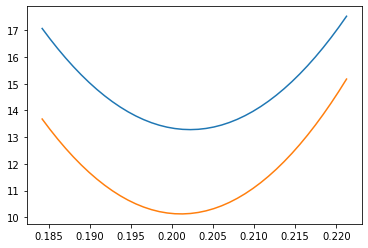

In [111]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [112]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )


  point for min chi2 :   19  val =  13.282
   0 :  x =   0.1842  chi2 =      17.07   dx = -0.0180  dchi2 =  3.7889
   1 :  x =   0.1852  chi2 =      16.68   dx = -0.0171  dchi2 =  3.3999
   2 :  x =   0.1861  chi2 =      16.31   dx = -0.0161  dchi2 =  3.0320
   3 :  x =   0.1871  chi2 =      15.97   dx = -0.0152  dchi2 =  2.6851
   4 :  x =   0.1880  chi2 =      15.64   dx = -0.0142  dchi2 =  2.3593
   5 :  x =   0.1890  chi2 =      15.34   dx = -0.0133  dchi2 =  2.0546
   6 :  x =   0.1899  chi2 =      15.05   dx = -0.0123  dchi2 =  1.7708
   7 :  x =   0.1909  chi2 =      14.79   dx = -0.0114  dchi2 =  1.5082
   8 :  x =   0.1918  chi2 =      14.55   dx = -0.0104  dchi2 =  1.2666
   9 :  x =   0.1928  chi2 =      14.33   dx = -0.0095  dchi2 =  1.0460
  10 :  x =   0.1937  chi2 =      14.13   dx = -0.0085  dchi2 =  0.8466
  11 :  x =   0.1947  chi2 =      13.95   dx = -0.0076  dchi2 =  0.6682
  12 :  x =   0.1956  chi2 =      13.79   dx = -0.0066  dchi2 =  0.5108
  13 :  x =   0.1966 

In [113]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   18  val =  10.124
   0 :  x =   0.1842  chi2 =      13.68   dx = -0.0171  dchi2 =  3.5550
   1 :  x =   0.1852  chi2 =      13.29   dx = -0.0161  dchi2 =  3.1664
   2 :  x =   0.1861  chi2 =      12.92   dx = -0.0152  dchi2 =  2.8003
   3 :  x =   0.1871  chi2 =      12.58   dx = -0.0142  dchi2 =  2.4567
   4 :  x =   0.1880  chi2 =      12.26   dx = -0.0133  dchi2 =  2.1356
   5 :  x =   0.1890  chi2 =      11.96   dx = -0.0123  dchi2 =  1.8369
   6 :  x =   0.1899  chi2 =      11.68   dx = -0.0114  dchi2 =  1.5608
   7 :  x =   0.1909  chi2 =      11.43   dx = -0.0104  dchi2 =  1.3071
   8 :  x =   0.1918  chi2 =      11.20   dx = -0.0095  dchi2 =  1.0760
   9 :  x =   0.1928  chi2 =      10.99   dx = -0.0085  dchi2 =  0.8673
  10 :  x =   0.1937  chi2 =      10.80   dx = -0.0076  dchi2 =  0.6810
  11 :  x =   0.1947  chi2 =      10.64   dx = -0.0066  dchi2 =  0.5173
  12 :  x =   0.1956  chi2 =      10.50   dx = -0.0057  dchi2 =  0.3760
  13 :  x =   0.1966 

In [114]:
n_scan_points = 40

scan_min = parhat[2] - 2*sigma_parhat[2]
scan_max = parhat[2] + 2*sigma_parhat[2]

#scan_min = 0.18
#scan_max = 0.22

scan_chi2_vals = np.zeros( n_scan_points )
scan_par_vals = np.zeros( n_scan_points )
scan_chi2_vals_diagonal = np.zeros( n_scan_points )

for si in range(n_scan_points) :

    scan_par_vals[si] = scan_min + si * (scan_max-scan_min) / (n_scan_points-1)
    
    model_mu = 0.2
    model_cov = scan_par_vals[si]
    model_sigma = np.sqrt(model_cov)

    model_norm = bin_width * hist_sum / ( model_sigma * np.sqrt( 2 * 3.14159265 ) )

    model_pred = model_norm * np.exp( -0.5 * np.square((hist_bin_centers - model_mu)/model_sigma) )
    
    dy = unfolded_hist - model_pred
    
    #cov_inv_times_dy = np.tensordot( hist_cov_inv, dy.T, axes=(1,0) )
    cov_inv_times_dy = np.tensordot( hist_cov_pinv, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy =  np.sum( dy.T * cov_inv_times_dy, axis=0)
    
    scan_chi2_vals[si] = dy_times_cov_inv_times_dy

    
    cov_inv_times_dy_diagonal = np.tensordot( hist_cov_inv_diagonal, dy.T, axes=(1,0) )
    dy_times_cov_inv_times_dy_diagonal =  np.sum( dy.T * cov_inv_times_dy_diagonal, axis=0)
    
    scan_chi2_vals_diagonal[si] = dy_times_cov_inv_times_dy_diagonal
    
    
    
    print(' scan point %3d  par %7.3f  chi2 = %15.2f,   diagonal chi2 = %15.2f' % 
          (si, scan_par_vals[si], scan_chi2_vals[si], scan_chi2_vals_diagonal[si]) )

    

 scan point   0  par   0.789  chi2 =           15.85,   diagonal chi2 =           14.10
 scan point   1  par   0.790  chi2 =           15.52,   diagonal chi2 =           13.68
 scan point   2  par   0.791  chi2 =           15.21,   diagonal chi2 =           13.29
 scan point   3  par   0.793  chi2 =           14.92,   diagonal chi2 =           12.91
 scan point   4  par   0.794  chi2 =           14.66,   diagonal chi2 =           12.57
 scan point   5  par   0.795  chi2 =           14.42,   diagonal chi2 =           12.24
 scan point   6  par   0.796  chi2 =           14.20,   diagonal chi2 =           11.94
 scan point   7  par   0.798  chi2 =           14.01,   diagonal chi2 =           11.66
 scan point   8  par   0.799  chi2 =           13.84,   diagonal chi2 =           11.41
 scan point   9  par   0.800  chi2 =           13.69,   diagonal chi2 =           11.18
 scan point  10  par   0.801  chi2 =           13.57,   diagonal chi2 =           10.97
 scan point  11  par   0.802  ch

<function matplotlib.pyplot.show(close=None, block=None)>

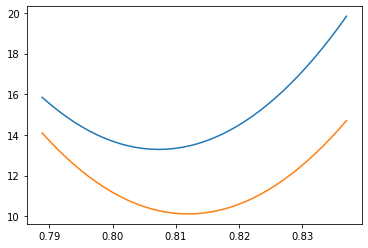

In [115]:
plt.plot(scan_par_vals, scan_chi2_vals)
plt.plot(scan_par_vals, scan_chi2_vals_diagonal)
plt.show

In [116]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals[si] < min_chi2 :
        min_chi2 = scan_chi2_vals[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals[si] - scan_chi2_vals[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals[si], dx, dchi2)
         )

  point for min chi2 :   15  val =  13.285
   0 :  x =   0.7889  chi2 =      15.85   dx = -0.0185  dchi2 =  2.5638
   1 :  x =   0.7901  chi2 =      15.52   dx = -0.0173  dchi2 =  2.2315
   2 :  x =   0.7914  chi2 =      15.21   dx = -0.0160  dchi2 =  1.9223
   3 :  x =   0.7926  chi2 =      14.92   dx = -0.0148  dchi2 =  1.6363
   4 :  x =   0.7938  chi2 =      14.66   dx = -0.0136  dchi2 =  1.3734
   5 :  x =   0.7951  chi2 =      14.42   dx = -0.0123  dchi2 =  1.1336
   6 :  x =   0.7963  chi2 =      14.20   dx = -0.0111  dchi2 =  0.9168
   7 :  x =   0.7975  chi2 =      14.01   dx = -0.0099  dchi2 =  0.7231
   8 :  x =   0.7988  chi2 =      13.84   dx = -0.0086  dchi2 =  0.5524
   9 :  x =   0.8000  chi2 =      13.69   dx = -0.0074  dchi2 =  0.4047
  10 :  x =   0.8012  chi2 =      13.57   dx = -0.0062  dchi2 =  0.2800
  11 :  x =   0.8024  chi2 =      13.46   dx = -0.0049  dchi2 =  0.1782
  12 :  x =   0.8037  chi2 =      13.38   dx = -0.0037  dchi2 =  0.0993
  13 :  x =   0.8049 

In [117]:
si_for_min = 0
min_chi2 = 1e9

for si in range(n_scan_points) :
    if scan_chi2_vals_diagonal[si] < min_chi2 :
        min_chi2 = scan_chi2_vals_diagonal[si]
        si_for_min = si
        
print('  point for min chi2 :  %3d  val = %7.3f' % (si_for_min, min_chi2))

for si in range(n_scan_points) :
    
    dx = scan_par_vals[si] - scan_par_vals[si_for_min]
    dchi2 = scan_chi2_vals_diagonal[si] - scan_chi2_vals_diagonal[si_for_min]
    
    print(' %3d :  x = %8.4f  chi2 = %10.2f   dx = %7.4f  dchi2 = %7.4f' %
          (si, scan_par_vals[si], scan_chi2_vals_diagonal[si], dx, dchi2)
         )


  point for min chi2 :   19  val =  10.112
   0 :  x =   0.7889  chi2 =      14.10   dx = -0.0234  dchi2 =  3.9848
   1 :  x =   0.7901  chi2 =      13.68   dx = -0.0222  dchi2 =  3.5675
   2 :  x =   0.7914  chi2 =      13.29   dx = -0.0210  dchi2 =  3.1736
   3 :  x =   0.7926  chi2 =      12.91   dx = -0.0197  dchi2 =  2.8029
   4 :  x =   0.7938  chi2 =      12.57   dx = -0.0185  dchi2 =  2.4555
   5 :  x =   0.7951  chi2 =      12.24   dx = -0.0173  dchi2 =  2.1312
   6 :  x =   0.7963  chi2 =      11.94   dx = -0.0160  dchi2 =  1.8300
   7 :  x =   0.7975  chi2 =      11.66   dx = -0.0148  dchi2 =  1.5519
   8 :  x =   0.7988  chi2 =      11.41   dx = -0.0136  dchi2 =  1.2969
   9 :  x =   0.8000  chi2 =      11.18   dx = -0.0123  dchi2 =  1.0648
  10 :  x =   0.8012  chi2 =      10.97   dx = -0.0111  dchi2 =  0.8557
  11 :  x =   0.8024  chi2 =      10.78   dx = -0.0099  dchi2 =  0.6695
  12 :  x =   0.8037  chi2 =      10.62   dx = -0.0086  dchi2 =  0.5062
  13 :  x =   0.8049 

In [118]:
boot_hist_content.shape

(500, 20)

In [119]:
len(boot_hist_content)

500

In [120]:

chi2_fit_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_sig2_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_mu_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_mu_err = np.zeros( len(boot_hist_content) )

chi2_fit_diag_sig2_val = np.zeros( len(boot_hist_content) )
chi2_fit_diag_sig2_err = np.zeros( len(boot_hist_content) )



for si in range( len(boot_hist_content) ) :
    
    # Initialize Minuit and set up fit:
    theta = 1
    mu = 0.2
    sigma2 = 0.81
    #fitType = 'full cov'

    parin   = np.array([theta, mu, sigma2])      # initial values (here = true)
    parname = ['theta', 'mu', 'sigma2']
    parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma^2$']
    parstep = np.array([0.01, 0.1, 0.1])           # initial setp sizes
    parfix  = [False, False, False]            # change to fix/free param.
    parlim  = [(0.5, 1.5), (None, None), (0., None)]

    chisq = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_pinv, fitType)
    chisq_diag = ChiSquared( boot_hist_content[si], hist_bin_edges, hist_cov_inv_diagonal, fitType)


    m = Minuit(chisq, parin, name=parname)
    m.errors = parstep
    m.fixed = parfix
    m.limits = parlim
    m.errordef = 1.0                      # errors from chi2 = chi2min + 1


    m_diag = Minuit(chisq_diag, parin, name=parname)
    m_diag.errors = parstep
    m_diag.fixed = parfix
    m_diag.limits = parlim
    m_diag.errordef = 1.0                      # errors from chi2 = chi2min + 1    
    
    
    # do the fit, get errors, extract results
    m.migrad()                                        # minimize -logL
    parhat = m.values                                 # max-likelihood estimates
    sigma_parhat = m.errors                           # standard deviations
    cov = m.covariance                                # covariance matrix
    rho = m.covariance.correlation()                  # correlation coeffs.

    m_diag.migrad()                                        # minimize -logL
    parhat_diag = m_diag.values                                 # max-likelihood estimates
    sigma_parhat_diag = m_diag.errors                           # standard deviations
    cov_diag = m_diag.covariance                                # covariance matrix
    rho_diag = m_diag.covariance.correlation()                  # correlation coeffs.

    
    chi2_fit_mu_val[si] = parhat[1]
    chi2_fit_mu_err[si] = sigma_parhat[1]

    chi2_fit_sig2_val[si] = parhat[2]
    chi2_fit_sig2_err[si] = sigma_parhat[2]

    
    chi2_fit_diag_mu_val[si] = parhat_diag[1]
    chi2_fit_diag_mu_err[si] = sigma_parhat_diag[1]

    chi2_fit_diag_sig2_val[si] = parhat_diag[2]
    chi2_fit_diag_sig2_err[si] = sigma_parhat_diag[2]

    
    

    
    
    
    print(' %3d : mu %8.4f +/- %8.4f  (%8.4f +/- %8.4f)    sig2 %8.4f +/- %8.4f  (%8.4f +/- %8.4f)' %
          (si, 
           parhat[1], sigma_parhat[1],
           parhat_diag[1], sigma_parhat_diag[1],
           parhat[2], sigma_parhat[2],
           parhat_diag[2], sigma_parhat_diag[2],
          )
         )
    

   0 : mu   0.1836 +/-   0.0093  (  0.1846 +/-   0.0090)    sig2   0.8229 +/-   0.0123  (  0.8201 +/-   0.0119)
   1 : mu   0.2133 +/-   0.0093  (  0.2115 +/-   0.0090)    sig2   0.8352 +/-   0.0123  (  0.8364 +/-   0.0119)
   2 : mu   0.1899 +/-   0.0093  (  0.1900 +/-   0.0090)    sig2   0.8257 +/-   0.0123  (  0.8284 +/-   0.0118)
   3 : mu   0.1963 +/-   0.0093  (  0.1937 +/-   0.0089)    sig2   0.8219 +/-   0.0123  (  0.8216 +/-   0.0119)
   4 : mu   0.2070 +/-   0.0093  (  0.2078 +/-   0.0090)    sig2   0.8308 +/-   0.0124  (  0.8297 +/-   0.0120)
   5 : mu   0.1990 +/-   0.0093  (  0.1995 +/-   0.0089)    sig2   0.8046 +/-   0.0120  (  0.8069 +/-   0.0116)
   6 : mu   0.1958 +/-   0.0093  (  0.1987 +/-   0.0089)    sig2   0.8315 +/-   0.0123  (  0.8321 +/-   0.0119)
   7 : mu   0.1921 +/-   0.0093  (  0.1918 +/-   0.0089)    sig2   0.8222 +/-   0.0123  (  0.8208 +/-   0.0119)
   8 : mu   0.1922 +/-   0.0093  (  0.1950 +/-   0.0090)    sig2   0.8359 +/-   0.0123  (  0.8370 +/-   

  87 : mu   0.2020 +/-   0.0093  (  0.2024 +/-   0.0089)    sig2   0.8215 +/-   0.0123  (  0.8218 +/-   0.0119)
  88 : mu   0.1801 +/-   0.0093  (  0.1775 +/-   0.0089)    sig2   0.8097 +/-   0.0123  (  0.8107 +/-   0.0119)
  89 : mu   0.2167 +/-   0.0093  (  0.2177 +/-   0.0090)    sig2   0.8225 +/-   0.0124  (  0.8199 +/-   0.0120)
  90 : mu   0.1949 +/-   0.0093  (  0.1979 +/-   0.0089)    sig2   0.8159 +/-   0.0123  (  0.8170 +/-   0.0119)
  91 : mu   0.2079 +/-   0.0093  (  0.2058 +/-   0.0090)    sig2   0.8424 +/-   0.0122  (  0.8416 +/-   0.0118)
  92 : mu   0.1773 +/-   0.0093  (  0.1782 +/-   0.0089)    sig2   0.8087 +/-   0.0122  (  0.8073 +/-   0.0117)
  93 : mu   0.1995 +/-   0.0093  (  0.1989 +/-   0.0090)    sig2   0.8118 +/-   0.0121  (  0.8122 +/-   0.0117)
  94 : mu   0.2037 +/-   0.0093  (  0.2049 +/-   0.0090)    sig2   0.8390 +/-   0.0125  (  0.8388 +/-   0.0120)
  95 : mu   0.2117 +/-   0.0093  (  0.2119 +/-   0.0090)    sig2   0.8169 +/-   0.0123  (  0.8210 +/-   

 181 : mu   0.1967 +/-   0.0093  (  0.1950 +/-   0.0089)    sig2   0.8152 +/-   0.0123  (  0.8125 +/-   0.0118)
 182 : mu   0.1909 +/-   0.0093  (  0.1905 +/-   0.0089)    sig2   0.7929 +/-   0.0119  (  0.7924 +/-   0.0115)
 183 : mu   0.1906 +/-   0.0093  (  0.1906 +/-   0.0090)    sig2   0.8296 +/-   0.0122  (  0.8291 +/-   0.0118)
 184 : mu   0.1989 +/-   0.0093  (  0.1983 +/-   0.0090)    sig2   0.8214 +/-   0.0122  (  0.8210 +/-   0.0118)
 185 : mu   0.2014 +/-   0.0093  (  0.2000 +/-   0.0090)    sig2   0.8175 +/-   0.0122  (  0.8149 +/-   0.0118)
 186 : mu   0.2042 +/-   0.0093  (  0.2055 +/-   0.0089)    sig2   0.7993 +/-   0.0121  (  0.7969 +/-   0.0117)
 187 : mu   0.2065 +/-   0.0093  (  0.2096 +/-   0.0089)    sig2   0.8037 +/-   0.0122  (  0.8026 +/-   0.0118)
 188 : mu   0.2092 +/-   0.0093  (  0.2102 +/-   0.0090)    sig2   0.8379 +/-   0.0124  (  0.8418 +/-   0.0120)
 189 : mu   0.2069 +/-   0.0093  (  0.2044 +/-   0.0090)    sig2   0.8106 +/-   0.0120  (  0.8087 +/-   

 280 : mu   0.2100 +/-   0.0093  (  0.2069 +/-   0.0090)    sig2   0.8294 +/-   0.0122  (  0.8281 +/-   0.0118)
 281 : mu   0.2110 +/-   0.0093  (  0.2108 +/-   0.0090)    sig2   0.8209 +/-   0.0122  (  0.8244 +/-   0.0118)
 282 : mu   0.2005 +/-   0.0093  (  0.1991 +/-   0.0090)    sig2   0.8104 +/-   0.0121  (  0.8089 +/-   0.0117)
 283 : mu   0.1992 +/-   0.0093  (  0.1969 +/-   0.0090)    sig2   0.8275 +/-   0.0123  (  0.8258 +/-   0.0119)
 284 : mu   0.2018 +/-   0.0093  (  0.2033 +/-   0.0090)    sig2   0.8372 +/-   0.0122  (  0.8351 +/-   0.0118)
 285 : mu   0.1851 +/-   0.0093  (  0.1870 +/-   0.0089)    sig2   0.8066 +/-   0.0119  (  0.8057 +/-   0.0116)
 286 : mu   0.1973 +/-   0.0093  (  0.1977 +/-   0.0089)    sig2   0.8015 +/-   0.0121  (  0.8021 +/-   0.0117)
 287 : mu   0.1920 +/-   0.0093  (  0.1902 +/-   0.0090)    sig2   0.8148 +/-   0.0122  (  0.8155 +/-   0.0118)
 288 : mu   0.2060 +/-   0.0093  (  0.2076 +/-   0.0089)    sig2   0.8018 +/-   0.0123  (  0.7986 +/-   

 373 : mu   0.2204 +/-   0.0093  (  0.2222 +/-   0.0090)    sig2   0.8291 +/-   0.0126  (  0.8310 +/-   0.0121)
 374 : mu   0.1840 +/-   0.0093  (  0.1845 +/-   0.0089)    sig2   0.8153 +/-   0.0122  (  0.8162 +/-   0.0118)
 375 : mu   0.2040 +/-   0.0093  (  0.2030 +/-   0.0090)    sig2   0.8459 +/-   0.0124  (  0.8445 +/-   0.0120)
 376 : mu   0.1964 +/-   0.0093  (  0.1937 +/-   0.0090)    sig2   0.8395 +/-   0.0125  (  0.8367 +/-   0.0120)
 377 : mu   0.2023 +/-   0.0093  (  0.2050 +/-   0.0089)    sig2   0.8077 +/-   0.0122  (  0.8094 +/-   0.0117)
 378 : mu   0.2055 +/-   0.0093  (  0.2020 +/-   0.0089)    sig2   0.8053 +/-   0.0121  (  0.8049 +/-   0.0117)
 379 : mu   0.1935 +/-   0.0093  (  0.1943 +/-   0.0089)    sig2   0.8196 +/-   0.0126  (  0.8166 +/-   0.0121)
 380 : mu   0.2115 +/-   0.0093  (  0.2111 +/-   0.0089)    sig2   0.8305 +/-   0.0123  (  0.8300 +/-   0.0118)
 381 : mu   0.1927 +/-   0.0093  (  0.1914 +/-   0.0090)    sig2   0.8182 +/-   0.0122  (  0.8169 +/-   

 472 : mu   0.2067 +/-   0.0093  (  0.2075 +/-   0.0090)    sig2   0.8213 +/-   0.0124  (  0.8209 +/-   0.0119)
 473 : mu   0.1951 +/-   0.0093  (  0.1962 +/-   0.0089)    sig2   0.8105 +/-   0.0121  (  0.8110 +/-   0.0117)
 474 : mu   0.1904 +/-   0.0093  (  0.1869 +/-   0.0090)    sig2   0.8204 +/-   0.0122  (  0.8189 +/-   0.0118)
 475 : mu   0.2016 +/-   0.0093  (  0.2017 +/-   0.0090)    sig2   0.8285 +/-   0.0122  (  0.8266 +/-   0.0118)
 476 : mu   0.2008 +/-   0.0093  (  0.2034 +/-   0.0090)    sig2   0.8142 +/-   0.0127  (  0.8142 +/-   0.0122)
 477 : mu   0.1957 +/-   0.0093  (  0.1981 +/-   0.0090)    sig2   0.8248 +/-   0.0121  (  0.8281 +/-   0.0117)
 478 : mu   0.1878 +/-   0.0093  (  0.1891 +/-   0.0090)    sig2   0.8280 +/-   0.0123  (  0.8328 +/-   0.0119)
 479 : mu   0.2051 +/-   0.0093  (  0.2068 +/-   0.0090)    sig2   0.8281 +/-   0.0124  (  0.8297 +/-   0.0120)
 480 : mu   0.1904 +/-   0.0093  (  0.1921 +/-   0.0090)    sig2   0.8481 +/-   0.0125  (  0.8465 +/-   

<function matplotlib.pyplot.show(close=None, block=None)>

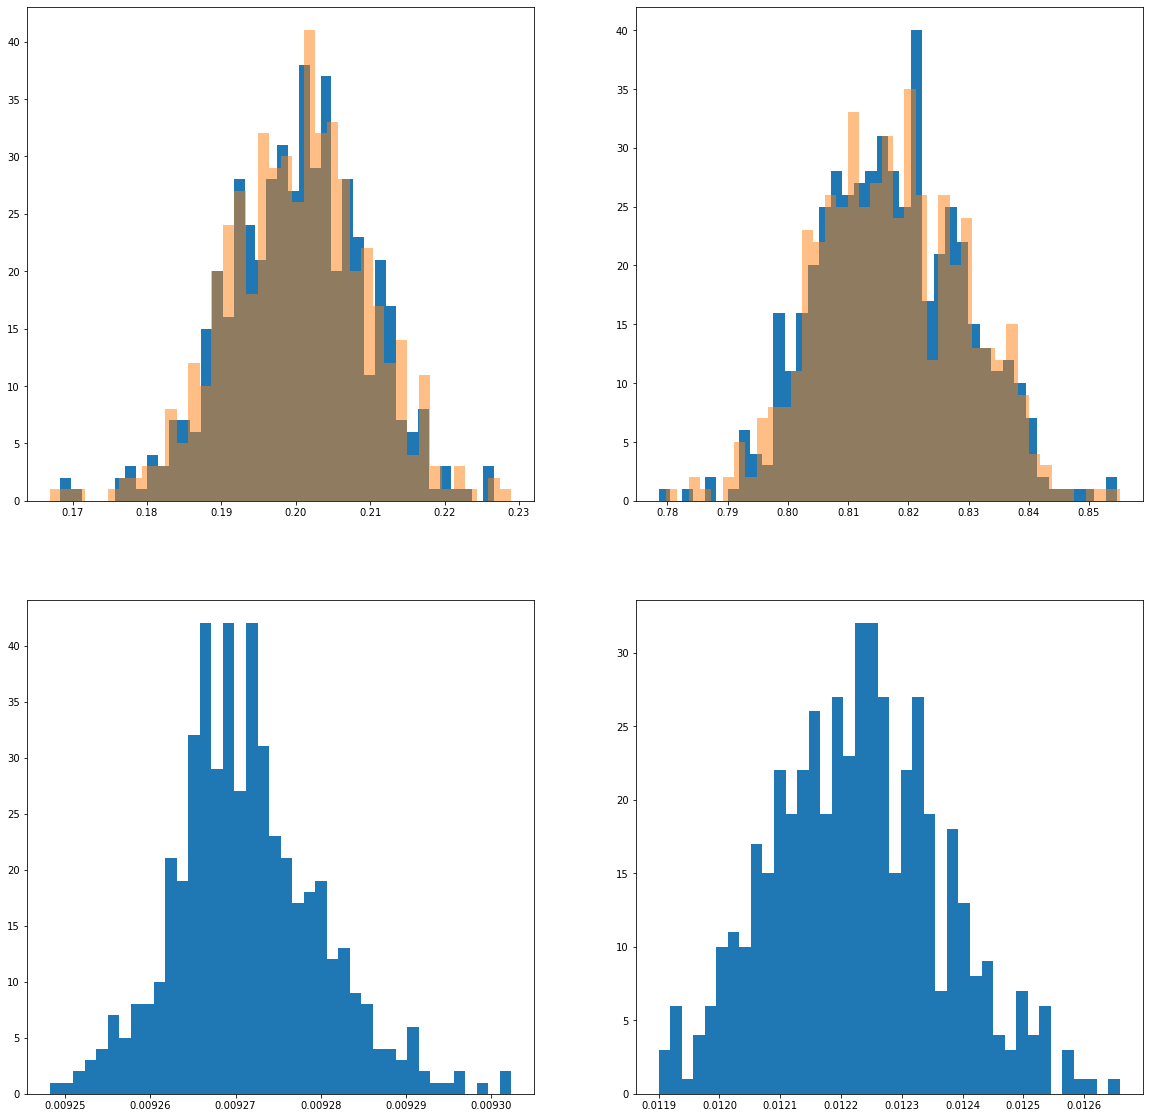

In [121]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].hist( chi2_fit_mu_val, bins=40 )
ax[0][0].hist( chi2_fit_diag_mu_val, bins=40, alpha=0.5 )

ax[0][1].hist( chi2_fit_sig2_val, bins=40 )
ax[0][1].hist( chi2_fit_diag_sig2_val, bins=40, alpha=0.5 )


ax[1][0].hist( chi2_fit_mu_err, bins=40 )

ax[1][1].hist( chi2_fit_sig2_err, bins=40 )


plt.show

In [122]:



mean_mu = np.mean( chi2_fit_mu_val )
mean_mu2 = np.mean( chi2_fit_mu_val * chi2_fit_mu_val )
rms_mu = np.sqrt( mean_mu2 - mean_mu * mean_mu )

mean_sig2 = np.mean( chi2_fit_sig2_val )
mean_sig22 = np.mean( chi2_fit_sig2_val * chi2_fit_sig2_val )
rms_sig2 = np.sqrt( mean_sig22 - mean_sig2 * mean_sig2 )

mean_mu_fit_err = np.mean( chi2_fit_mu_err )
mean_sig2_fit_err = np.mean( chi2_fit_sig2_err )





mean_mu_diag = np.mean( chi2_fit_diag_mu_val )
mean_mu2_diag = np.mean( chi2_fit_diag_mu_val * chi2_fit_diag_mu_val )
rms_mu_diag = np.sqrt( mean_mu2_diag - mean_mu_diag * mean_mu_diag )

mean_sig2_diag = np.mean( chi2_fit_diag_sig2_val )
mean_sig22_diag = np.mean( chi2_fit_diag_sig2_val * chi2_fit_diag_sig2_val )
rms_sig2_diag = np.sqrt( mean_sig22_diag - mean_sig2_diag * mean_sig2_diag )

mean_mu_fit_err_diag = np.mean( chi2_fit_diag_mu_err )
mean_sig2_fit_err_diag = np.mean( chi2_fit_diag_sig2_err )




print('\n\n')
print(' mean: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_mu, rms_mu, mean_mu_fit_err,    mean_mu_diag, rms_mu_diag, mean_mu_fit_err_diag))
print(' sig2: %7.4f, rms %7.4f, mean fit err %7.4f  |  diag. chi2 fit   %7.4f, rms %7.4f, mean fit err %7.4f' % 
      (mean_sig2, rms_sig2, mean_sig2_fit_err,   mean_sig2_diag, rms_sig2_diag, mean_sig2_fit_err_diag))
print('\n\n')






 mean:  0.2001, rms  0.0092, mean fit err  0.0093  |  diag. chi2 fit    0.2002, rms  0.0094, mean fit err  0.0090
 sig2:  0.8172, rms  0.0121, mean fit err  0.0122  |  diag. chi2 fit    0.8174, rms  0.0123, mean fit err  0.0118





<function matplotlib.pyplot.show(close=None, block=None)>

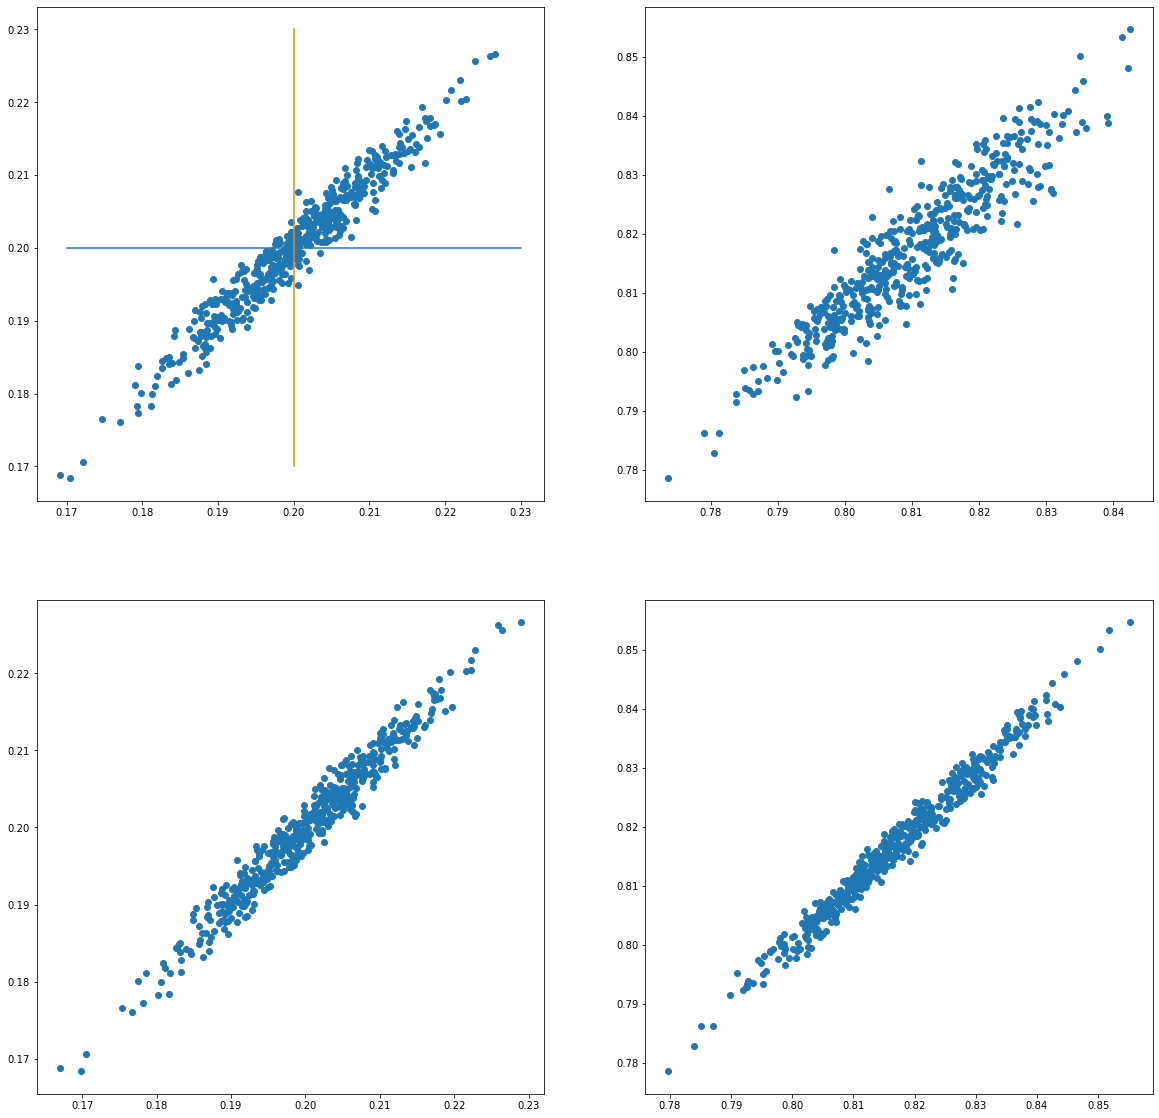

In [123]:
fig,ax = plt.subplots( 2, 2, figsize=(2*10,2*10))

ax[0][0].scatter( simple_calc_mean, chi2_fit_mu_val )
ax[0][1].scatter( simple_calc_cov, chi2_fit_sig2_val )
ax[0][0].plot( [0.17,0.23], [0.2,0.2])
ax[0][0].plot( [0.2,0.2], [0.17,0.23])


ax[1][0].scatter( chi2_fit_diag_mu_val, chi2_fit_mu_val )
ax[1][1].scatter( chi2_fit_diag_sig2_val, chi2_fit_sig2_val )

plt.show